# Cart2Text

In [7]:
import numpy as np
from scipy.spatial import ConvexHull

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    #bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    #box with best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    #best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval
import numpy as np
from sklearn.metrics import mutual_info_score


def ConvPixel(FVec, xp, yp, A, B, base=1, custom_cut=None, index=0):
    n = len(FVec)
    M = np.ones([int(A), int(B)]) * base
    for j in range(0, n):
        # M[int(xp[j]) - 1, int(yp[j]) - 1] = 0
        M[int(xp[j]) - 1, int(yp[j]) - 1] = FVec[j]
    zp = np.array([xp, yp])
    dup = {}
    # find duplicate
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)
                
    for index in dup.keys():
        x, y = index.split("-")
        M[int(float(x)) - 1, int(float(y)) - 1] = sum(FVec[list(dup[index])]) / len(dup[index])
    if custom_cut is not None:
      M = np.delete(M, range(0, custom_cut), 0)
    return M

import math
import pickle

import pandas as pd
import json as json
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import imageio

import numpy as np


def find_duplicate(zp):
    dup = {}
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)
    sum = 0
    for ind in dup.keys():
        sum = sum + (len(dup[ind]) - 1)
    return sum


def dataset_with_best_duplicates(X, y, zp):
    X = X.transpose()
    dup = {}
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)
    toDelete = []
    for index in dup.keys():
        mi = []
        x_new = X[:, list(dup[index])]
        mi = mutual_info_classif(x_new, y)
        max = np.argmax(mi)
        dup[index].remove(list(dup[index])[max])
        toDelete.extend(list(dup[index]))
    X = np.delete(X, toDelete, axis=1)
    zp = np.delete(zp, toDelete, axis=1)
    return X.transpose(), zp, toDelete

def count_model_col(rotatedData,Q,r1,r2):
    tot = []
    for f in range(r1-1, r2):
        A = f
        B = f
        xp = np.round(
            1 + (A * (rotatedData[0, :] - min(rotatedData[0, :])) / (max(rotatedData[0, :]) - min(rotatedData[0, :]))))
        yp = np.round(
            1 + (-B) * (rotatedData[1, :] - max(rotatedData[1, :])) / (max(rotatedData[1, :]) - min(rotatedData[1, :])))
        zp = np.array([xp, yp])
        A = max(xp)
        B = max(yp)

        # find duplicates
        sum=str(find_duplicate(zp))
        print("Collisioni: " + sum)
        tot.append([A,sum])
        a = ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B)
        plt.imshow(a, cmap="gray")
        plt.savefig(str(A)+'.png')
        plt.show()
    pd.DataFrame(tot).to_csv("Collision_autoencoder.csv")


def Cart2Pixel(Q=None, A=None, B=None, dynamic_size=False, mutual_info=False, only_model=False, params=None):
    # TODO controls on input
    if A is not None:
        A = A - 1
    if (B != None):
        B = B - 1
    # to dataframe
    feat_cols = ["col-" + str(i + 1) for i in range(Q["data"].shape[1])]
    df = pd.DataFrame(Q["data"], columns=feat_cols)
    if Q["method"] == 'pca':
        pca = PCA(n_components=2)
        Y = pca.fit_transform(df)
    elif Q["method"] == 'tSNE':
        tsne = TSNE(n_components=2, method="exact")
        Y = tsne.fit_transform(df)
    elif Q["method"] == 'kpca':
        kpca = KernelPCA(n_components=2, kernel='linear')
        Y = kpca.fit_transform(df)

    x = Y[:, 0]
    y = Y[:, 1]
    n, n_sample = Q["data"].shape
    bbox = minimum_bounding_rectangle(Y)
    grad = (bbox[1, 1] - bbox[0, 1]) / (bbox[1, 0] - bbox[0, 0])
    theta = np.arctan(grad)
    R = np.asmatrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    bboxMatrix = np.matrix(bbox)
    zrect = (R.dot(bboxMatrix.transpose())).transpose()
    coord = np.array([x, y])
    rotatedData = np.array(R.dot(coord))  # Z
    plt.scatter(rotatedData[0, :], rotatedData[1:])
    plt.axis('square')
    plt.show(block=False)

    # find duplicate
    for i in range(len(rotatedData[0, :])):
        for j in range(i + 1, len(rotatedData[0])):
            if rotatedData[0, i] == rotatedData[0, j] and rotatedData[1, i] == rotatedData[1, j]:
                print("duplicate:" + str(i) + " " + str(j))

    # nearest point

    min_dist = np.inf
    min_p1 = 0
    min_p2 = 0
    for p1 in range(n):
        for p2 in range(p1 + 1, n):
            d = (rotatedData[0, p1] - rotatedData[0, p2]) ** 2 + (rotatedData[1, p1] - rotatedData[1, p2]) ** 2
            if min_dist > d > 0 and p1 != p2:
                min_p1 = p1
                min_p2 = p2
                min_dist = d

    # euclidean distance
    dmin = np.linalg.norm(rotatedData[:, min_p1] - rotatedData[:, min_p2])
    rec_x_axis = abs(zrect[0, 0] - zrect[1, 0])
    rec_y_axis = abs(zrect[1, 1] - zrect[2, 1])

    if dynamic_size:
        precision_old = math.sqrt(2)
        A = math.ceil(rec_x_axis * precision_old / dmin)
        B = math.ceil(rec_y_axis * precision_old / dmin)
        print("Dynamic [A:" + str(A) + " ; B:" + str(B) + "]")
        if A > Q["max_A_size"] or B > Q["max_B_size"]:
            precision = precision_old * (Q["max_A_size"] / A) * (Q["max_B_size"] / B)
            A = math.ceil(rec_x_axis * precision / dmin)
            B = math.ceil(rec_y_axis * precision / dmin)
    # cartesian coordinates to pixels
    tot = []
    xp = np.round(
        1 + (A * (rotatedData[0, :] - min(rotatedData[0, :])) / (max(rotatedData[0, :]) - min(rotatedData[0, :]))))
    yp = np.round(
        1 + (-B) * (rotatedData[1, :] - max(rotatedData[1, :])) / (max(rotatedData[1, :]) - min(rotatedData[1, :])))
    # Modified Feature Position | custom cut
    cut = params["cut"]
    if cut is not None:
      assert True
      xp[59] = cut

    zp = np.array([xp, yp])
    A = max(xp)
    B = max(yp)

    # find duplicates
    print("Collisioni: " + str(find_duplicate(zp)))


    # Training set

    images = []
    toDelete = 0
    name = "_" + str(int(A)) + 'x' + str(int(B))
    if params["No_0_MI"]:
        name = name + "_No_0_MI"
    if mutual_info:
        print("calc MI")
        Q["data"], zp, toDelete = dataset_with_best_duplicates(Q["data"], Q["y"], zp)
        name = name + "_MI"
        print("MI done")


    else:
        name = name + "_Mean"
    if cut is not None:
        name = name + "_Cut"+str(cut)
    if only_model:
        a = ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B)
        plt.imshow(a, cmap="gray")
        plt.show()
    else:
        a=ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B, index=i)
        plt.imshow(a,cmap="gray")
        plt.show()
        print("Create images")
        if cut is not None:
          images = [ConvPixel(Q["data"][:, i], zp[0], zp[1], A, B, custom_cut=cut-1, index=i) for i in range(0, n_sample)]
        else:
          images = [ConvPixel(Q["data"][:, i], zp[0], zp[1], A, B, index=i) for i in range(0, n_sample)]

        filename = params["dir"] + "train" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(images, f_myfile)
        f_myfile.close()
        filename = params["res"] + "train" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(images, f_myfile)
        f_myfile.close()

    image_model = {"xp": zp[0].tolist(), "yp": zp[1].tolist(), "A": A, "B": B, "custom_cut": cut}


    return images, image_model, toDelete


# Neural

In [8]:
import numpy as np
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Add, \
    Concatenate, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight



def CNN_Nature(images, y, param=None):
    print(param)
    x_train, x_test, y_train, y_test = train_test_split(images,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=100)
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    image_size = x_train.shape[1]
    image_size2 = x_train.shape[2]

    x_train = np.reshape(x_train, [-1, image_size, image_size2, 1])
    x_test = np.reshape(x_test, [-1, image_size, image_size2, 1])

    num_filters = param["filter"]
    num_filters2 = param["filter2"]

    kernel = param["kernel"]

    inputs = Input(shape=(image_size, image_size2, 1))
    print(x_train.shape)
    out = Conv2D(filters=num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(strides=2, pool_size=2)(out)

    out = Conv2D(filters=2 * num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(strides=2, pool_size=2)(out)

    out = Conv2D(filters=4 * num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    # layer 2
    out2 = Conv2D(filters=num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(inputs)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    out2 = MaxPooling2D(strides=2, pool_size=2)(out2)

    out2 = Conv2D(filters=2 * num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    out2 = MaxPooling2D(strides=2, pool_size=2)(out2)

    out2 = Conv2D(filters=4 * num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)

    # final layer
    outf = Concatenate()([out, out2])
    out_f = AveragePooling2D(strides=2, pool_size=2)(outf)
    out_f = Flatten()(out_f)
    predictions = Dense(5, activation='softmax')(out_f)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)

    adam = Adam(lr=param["learning_rate"])

    # Compile the model.
    model.compile(
        optimizer=adam,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}  # Convert to dictionary format

    # Train the model.
    hist = model.fit(
        x_train,
        y_train,
        epochs=param["epoch"],
        verbose=2,
        validation_data=(x_test, y_test),
        batch_size=param["batch"],
        class_weight=class_weights_dict,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10),
                   ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)]
    )
    model.load_weights('best_model.keras')

    y_test = np.argmax(y_test, axis=1)

    Y_predicted = model.predict(x_test, verbose=0)

    Y_predicted = np.argmax(Y_predicted, axis=1)

    cf = confusion_matrix(y_test, Y_predicted)

    return model, {"balanced_accuracy_val": balanced_accuracy_score(y_test, Y_predicted) * 100, "TP_val": cf[0][0],
                   "FN_val": cf[0][1], "FP_val": cf[1][0], "TN_val": cf[1][1]
                   }


def CNN2(images, y, params=None):
    print(params)
    x_train, x_test, y_train, y_test = train_test_split(images,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=100
                                                        )
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    image_size = x_train.shape[1]
    image_size2 = x_train.shape[2]

    x_train = np.reshape(x_train, [-1, image_size, image_size2, 1])
    x_test = np.reshape(x_test, [-1, image_size, image_size2, 1])


    kernel = params["kernel"]
    kernel2=int(kernel/2)
    inputs = Input(shape=(image_size, image_size2, 1))

    X = Conv2D(32, (kernel,kernel), activation='relu', name='conv0')(inputs)
    X = Dropout(rate=params['dropout1'])(X)
    X = Conv2D(64, (kernel, kernel), activation='relu', name='conv1')(X)
    X = Dropout(rate=params['dropout2'])(X)
    X = Conv2D(128, (kernel, kernel), activation='relu', name='conv2')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', kernel_initializer='glorot_uniform')(X)
    X = Dense(1024, activation='relu', kernel_initializer='glorot_uniform')(X)
    X = Dense(5, activation='softmax', kernel_initializer='glorot_uniform')(X)

    model = Model(inputs, X)
    adam = Adam(params["learning_rate"])

    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['acc'])

    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}  # Convert to dictionary format

    # Train the model.
    hist = model.fit(
        x_train,
        y_train,
        epochs=params["epoch"],
        verbose=2,
        validation_data=(x_test, y_test),
        batch_size=params["batch"],
        class_weight=class_weights_dict,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10),
                   ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)]
    )
    model.load_weights('best_model.keras')

    y_test = np.argmax(y_test, axis=1)

    Y_predicted = model.predict(x_test, verbose=0)

    Y_predicted = np.argmax(Y_predicted, axis=1)

    cf = confusion_matrix(y_test, Y_predicted)

    return model, {"balanced_accuracy_val": balanced_accuracy_score(y_test, Y_predicted) * 100, "TP_val": cf[0][0],
                   "FN_val": cf[0][1], "FP_val": cf[1][0], "TN_val": cf[1][1]
                   }


# Train

In [10]:
import csv
import json
import pickle
import timeit

import numpy as np
from hyperopt import STATUS_OK
from hyperopt import tpe, hp, Trials, fmin
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import time

XGlobal = []
YGlobal = []

XTestGlobal = []
YTestGlobal = []

SavedParameters = []
Mode = ""
Name = ""
best_val_acc = 0
path_model=""


ds = 1
train = 0
test = 0

if ds == 1:
    #train = 20000/100*20  # attacchi
    train=6857
    test = 180000
elif ds == 2:
    train = 9067
    test = 119341
else:
    train = 79349
    test = 250436

def fix(f):
    a = f["TN_val"]
    b = f["FP_val"]
    c = f["FN_val"]
    d = f["TP_val"]
    f["TN_val"] = d
    f["TP_val"] = a
    f["FP_val"] = c
    f["FN_val"] = b
    return f


def fix_test(f):
    a = f["TN_test"]
    b = f["FP_test"]
    c = f["FN_test"]
    d = f["TP_test"]
    f["TN_test"] = d
    f["TP_test"] = a
    f["FP_test"] = c
    f["FN_test"] = b
    return f

def res(cm, val):
    tp = cm[0][0]  # attacks true
    fn = cm[0][1]  # attacs predict normal
    fp = cm[1][0]  # normal predict attacks
    tn = cm[1][1]  # normal as normal
    attacks = tp + fn
    normals = fp + tn
    print(attacks)
    print(normals)


    if attacks <= normals:
        print("ok")
    elif not val:
        print("error")
        return False,False
    OA = (tp + tn) / (attacks + normals)
    AA = ((tp / attacks) + (tn / normals)) / 2
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * ((P * R) / (P + R))
    FAR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    r = [OA, AA, P, R, F1, FAR, TPR]
    return True,r

def hyperopt_fcn(params):
    if Mode == "CNN_Nature":
      if params["filter"] == params["filter2"] :
          return {'loss': np.inf, 'status': STATUS_OK}
    global SavedParameters
    start_time = time.time()
    print("start train")
    if Mode == "CNN_Nature":
        model, val = CNN_Nature(XGlobal, YGlobal, params)
    elif Mode == "CNN2":
        model, val = CNN2(XGlobal, YGlobal, params)
    print("start predict")
    print(XTestGlobal.shape)
    print(YTestGlobal.shape)
    Y_predicted = model.predict(XTestGlobal, verbose=0)
    Y_predicted = np.argmax(Y_predicted, axis=1)
    elapsed_time = time.time() - start_time
    cf = confusion_matrix(YTestGlobal, Y_predicted)
    K.clear_session()
    SavedParameters.append(val)
    global best_val_acc

    if Mode == "CNN_Nature":
        SavedParameters[-1].update({"balanced_accuracy_test": balanced_accuracy_score(YTestGlobal, Y_predicted) *
                                                              100, "TP_test": cf[0][0], "FN_test": cf[0][1],
                                    "FP_test": cf[1][0], "TN_test": cf[1][1], "kernel": params[
                "kernel"], "learning_rate": params["learning_rate"], "batch": params["batch"],
                                    "filter1": params["filter"],
                                    "filter2": params["filter2"],
                                    "time": time.strftime("%H:%M:%S", time.gmtime(elapsed_time))})
    elif Mode == "CNN2":
        SavedParameters[-1].update(
            {"balanced_accuracy_test": balanced_accuracy_score(YTestGlobal, Y_predicted) * 100, "TN_test": cf[0][0],
             "FP_test": cf[0][1], "FN_test": cf[1][0], "TP_test": cf[1][1], "kernel": params["kernel"],
             "learning_rate": params["learning_rate"],
             "batch": params["batch"],
             "time": time.strftime("%H:%M:%S", time.gmtime(elapsed_time))})
    cm_val = [[SavedParameters[-1]["TP_val"], SavedParameters[-1]["FN_val"]],
              [SavedParameters[-1]["FP_val"], SavedParameters[-1]["TN_val"]]]

    done,r = res(cm_val, True)
    if not done:
        SavedParameters[-1]=fix(SavedParameters[-1])
        cm_val = [[SavedParameters[-1]["TP_val"], SavedParameters[-1]["FN_val"]],
              [SavedParameters[-1]["FP_val"], SavedParameters[-1]["TN_val"]]]
        done, r = res(cm_val, True)
    assert done==True
    SavedParameters[-1].update({
        "OA_val": r[0],
        "P_val": r[2],
        "R_val": r[3],
        "F1_val": r[4],
        "FAR_val": r[5],
        "TPR_val": r[6]
    })
    cm_test = [[SavedParameters[-1]["TP_test"], SavedParameters[-1]["FN_test"]],
               [SavedParameters[-1]["FP_test"], SavedParameters[-1]["TN_test"]]]
    done, r = res(cm_test, False)
    if not done:
        SavedParameters[-1]=fix_test(SavedParameters[-1])
        cm_test = [[SavedParameters[-1]["TP_test"], SavedParameters[-1]["FN_test"]], [SavedParameters[-1]["FP_test"], SavedParameters[-1]["TN_test"]]]
        done, r = res(cm_test, False)
    assert done==True

    SavedParameters[-1].update({
        "OA_test": r[0],
        "P_test": r[2],
        "R_test": r[3],
        "F1_test": r[4],
        "FAR_test": r[5],
        "TPR_test": r[6]
    })
    #Save Model
    if SavedParameters[-1]["F1_val"] > best_val_acc:
        print("new saved model:" + str(SavedParameters[-1]))
        model.save(path_model)
        best_val_acc = SavedParameters[-1]["F1_val"]


    SavedParameters = sorted(SavedParameters, key=lambda i: i['F1_test'], reverse=True)

    try:
        with open(Name, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=SavedParameters[0].keys())
            writer.writeheader()
            writer.writerows(SavedParameters)
    except IOError:
        print("I/O error")
    print("prova"+str(val["F1_val"]))
    return {'loss': -val["F1_test"], 'status': STATUS_OK}


def train_norm(param, dataset, norm):
    np.random.seed(param["seed"])
    print("modelling dataset")
    global YGlobal
    YGlobal = to_categorical(dataset["Classification"])
    del dataset["Classification"]
    global YTestGlobal
    YTestGlobal = to_categorical(dataset["Ytest"])
    del dataset["Ytest"]

    global XGlobal
    global XTestGlobal

    if not param["LoadFromJson"]:
        # norm
        Out = {}
        if norm:
            print('NORM Min-Max')
            Out["Max"] = float(dataset["Xtrain"].max().max())
            Out["Min"] = float(dataset["Xtrain"].min().min())
            # NORM
            dataset["Xtrain"] = (dataset["Xtrain"] - Out["Min"]) / (Out["Max"] - Out["Min"])
            dataset["Xtrain"] = dataset["Xtrain"].fillna(0)

        # TODO implement norm 2
        print("trasposing")

        q = {"data": np.array(dataset["Xtrain"].values).transpose(), "method": param["Metod"],
             "max_A_size": param["Max_A_Size"], "max_B_size": param["Max_B_Size"], "y": np.argmax(YGlobal, axis=1)}
        print(q["method"])
        print(q["max_A_size"])
        print(q["max_B_size"])

        # generate images
        XGlobal, image_model, toDelete = Cart2Pixel(q, q["max_A_size"], q["max_B_size"], param["Dynamic_Size"],
                                                    mutual_info=param["mutual_info"], params=param)

        del q["data"]
        print("Train Images done!")
        # generate testingset image
        if param["mutual_info"]:
            dataset["Xtest"] = dataset["Xtest"].drop(dataset["Xtest"].columns[toDelete], axis=1)

        dataset["Xtest"] = np.array(dataset["Xtest"]).transpose()
        print("generating Test Images")
        print(dataset["Xtest"].shape)
        if image_model["custom_cut"] is not None:
          XTestGlobal = [ConvPixel(dataset["Xtest"][:, i], np.array(image_model["xp"]), np.array(image_model["yp"]),
                                  image_model["A"], image_model["B"],custom_cut=image_model["custom_cut"])
                        for i in range(0, dataset["Xtest"].shape[1])]
        else:
          XTestGlobal = [ConvPixel(dataset["Xtest"][:, i], np.array(image_model["xp"]), np.array(image_model["yp"]),
                                  image_model["A"], image_model["B"])
                        for i in range(0, dataset["Xtest"].shape[1])]
        print("Test Images done!")

        # saving testingset
        name = "_" + str(int(q["max_A_size"])) + "x" + str(int(q["max_B_size"]))
        if param["No_0_MI"]:
            name = name + "_No_0_MI"
        if param["mutual_info"]:
            name = name + "_MI"
        else:
            name = name + "_Mean"
        if image_model["custom_cut"] is not None:
            name = name + "_Cut" + str(image_model["custom_cut"])
        filename = param["dir"] + "test" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(XTestGlobal, f_myfile)
        f_myfile.close()

        filename = param["res"] + "test" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(XTestGlobal, f_myfile)
        f_myfile.close()
    else:
        XGlobal = dataset["Xtrain"]
        XTestGlobal = dataset["Xtest"]
    del dataset["Xtrain"]
    del dataset["Xtest"]
    XTestGlobal = np.array(XTestGlobal)
    image_size1 = XTestGlobal.shape[1]
    image_size2 = XTestGlobal.shape[2]
    print("shape" + str(XTestGlobal.shape))
    XTestGlobal = np.reshape(XTestGlobal, [-1, image_size1, image_size2, 1])
    YTestGlobal = np.argmax(YTestGlobal, axis=1)
    print(XTestGlobal.shape)
    print(YTestGlobal.shape)
  
    if param["Mode"] == "CNN_Nature":
        optimizable_variable = {"kernel": hp.choice("kernel", np.arange(2, 4 + 1)),
                                "filter": hp.choice("filter", [16, 32, 64, 128]),
                                "filter2": hp.choice("filter2", [16, 32, 64, 128]),
                                "batch": hp.choice("batch", [16]),
                                "learning_rate": hp.uniform("learning_rate", 0.0001, 0.01),
                                "epoch": param["epoch"]}
    elif param["Mode"] == "CNN2":
        optimizable_variable = {"kernel": hp.choice("kernel", np.arange(2, 4 + 1)),
                                "batch": hp.choice("batch", [32, 64, 128, 256, 512]),
                                'dropout1': hp.uniform("dropout1", 0, 1),
                                'dropout2': hp.uniform("dropout2", 0, 1),
                                "learning_rate": hp.uniform("learning_rate",  0.0001, 0.001),
                                "epoch": param["epoch"]}
    global Mode
    Mode = param["Mode"]

    global Name
    Name = param["res"] + "res_" + str(int(param["Max_A_Size"])) + "x" + str(int(param["Max_B_Size"]))
    if param["No_0_MI"]:
        Name = Name + "_No_0_MI"
    if param["mutual_info"]:
        Name = Name + "_MI"
    else:
        Name = Name + "_Mean"
    Name = Name + "_" + Mode + ".csv"

    global path_model
    path_model=Name.replace(".csv","_model.h5")

    trials = Trials()
    fmin(hyperopt_fcn, optimizable_variable, trials=trials, algo=tpe.suggest, max_evals=param["hyper_opt_evals"])

    print("done")
    return 1


# ACGAN


In [12]:
# --- MULTI CLASS CLASSIFICATION ---

from tensorflow.keras.models import load_model
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf

# Configure TensorFlow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # Dynamically grow memory used on GPU
session = tf.compat.v1.InteractiveSession(config=config)

# Load trained ACGAN model
pathModel = 'D:/IDS/Code/Datasets/NSLKDD/acgan_aagm.h5'
generator = load_model(pathModel, compile=False)  # Load without compiling

# Parameters
param = {
    "Max_A_Size": 10, "Max_B_Size": 10, "Dynamic_Size": False, 'Metod': 'tSNE', "ValidRatio": 0.1, "seed": 180,
    "dir": "D:/IDS/Code/Datasets/NSLKDD/", "Mode": "CNN2",  # Mode: CNN_Nature, CNN2
    "LoadFromJson": False, "mutual_info": True,  # Mean or MI
    "hyper_opt_evals": 20, "epoch": 150, "No_0_MI": False,  # True -> Removing 0 MI Features
    "autoencoder": False, "cut": None
}

dim = 53330  # Number of synthetic samples to generate

# Load dataset
if param['mutual_info']:
    method = 'MI'
else:
    method = 'Mean'

with open(param["dir"] + f'train_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{method}.pickle', 'rb') as f:
    Xtrain = pickle.load(f)

with open(param["dir"] + 'YTrain.pickle', 'rb') as f:
    Ytrain = pickle.load(f)

# Convert to numpy arrays
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

print("Original Training Data Shape:", Xtrain.shape)
print("Original Labels Shape:", Ytrain.shape)

# **🔹 Generate Synthetic Attack Samples with Multi-Class Labels**
noise_input = np.random.uniform(-1.0, 1.0, size=[dim, 100])  # Random noise for generator

# Define multi-class labels (5 attack categories)
class_labels = np.random.randint(0, 5, size=(dim,))  # Random attack category assignment

# One-hot encode labels (for ACGAN)
noise_label = np.zeros((dim, 5))  # Change to 5 classes
noise_label[np.arange(dim), class_labels] = 1  # One-hot encoding

# Create input for generator
noise_input = [noise_input, noise_label]

# **🔹 Generate Synthetic Attack Data**
generator.summary()
predictions = generator.predict(noise_input)
predictions = tf.reshape(predictions, [dim, 10, 10])

print("Generated Samples Shape:", predictions.shape)

# Convert predictions to list
new_samples = predictions.numpy().tolist()

# **🔹 Add Generated Data to Training Set**
Xtrain = list(Xtrain)  # Convert to list
Xtrain.extend(new_samples)  # Add new generated samples

# Convert Ytrain to DataFrame for easy concatenation
Ytrain = pd.Series(Ytrain)

# Append **multi-class attack labels** instead of just 1s
Ytrain = pd.concat([Ytrain, pd.Series(class_labels)], ignore_index=True)

print("Updated Training Data Shape:", len(Xtrain))
print("Updated Labels Shape:", len(Ytrain))

# Save updated datasets
with open(param["dir"] + 'XTrain50A%.pickle', 'wb') as f:
    pickle.dump(Xtrain, f)

with open(param["dir"] + 'YTrain50A%.pickle', 'wb') as f:
    pickle.dump(Ytrain, f)

print("✅ Multi-Class Synthetic Attack Samples Added Successfully!")

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.
Original Training Data Shape: (125973, 10, 10)
Original Labels Shape: (125973,)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_input             │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labels (InputLayer) │ (None, 5)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 105)       │          0 │ z_input[0][0],    │
│ (Concatenate)       │                   │            │ labels[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6400)      │    678,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5, 256) │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5, 5, 256) │      1,024 │ reshape[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 5, 5, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 10, 10,    │  1,638,656 │ activation_1[0][… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 10, 10,    │    819,328 │ activation_2[0][… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 10, 10,    │    204,864 │ activation_3[0][… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 10, 10,    │     51,232 │ activation_4[0][… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        128 │ conv2d_transpose

 Total params: 3,396,225 (12.96 MB)

 Trainable params: 3,394,753 (12.95 MB)

 Non-trainable params: 1,472 (5.75 KB)

1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step
Generated Samples Shape: (53330, 10, 10)
Updated Training Data Shape: 179303
Updated Labels Shape: 179303
✅ Multi-Class Synthetic Attack Samples Added Successfully!


In [15]:
import pickle
import pandas as pd

# Function to count normal and attack samples in a pickle label file
def count_labels():

    xtrain50A_pickle_path = "D:/IDS/Code/Datasets/NSLKDD/XTrain50A%.pickle"
    ytrain50A_pickle_path = "D:/IDS/Code/Datasets/NSLKDD/YTrain50A%.pickle"
    try:
        with open(xtrain50A_pickle_path, "rb") as f:
            xtrain = pickle.load(f)
        with open(ytrain50A_pickle_path, "rb") as f:
            ytrain = pickle.load(f)
          # Convert to Pandas Series (if not already)
        normal_count = (ytrain == 0).sum()
        attack_count = (ytrain == 1).sum()

        print(f" - Normal Samples: {normal_count}")
        print(f" - Attack Samples: {attack_count}\n")
    except Exception as e:
        print(f"Error loading : {e}")

# Count labels in the pickle files
count_labels()
train_csv_path = "D:/IDS/Code/Datasets/NSL_KDD_Train.csv"

# Count labels in the Train.csv file
try:
    df = pd.read_csv(train_csv_path)
    class_column = "classification"  # Ensure this matches exactly with Train.csv
    normal_count = (df[class_column] == 0).sum()
    attack_count = (df[class_column] == 1).sum()
    print(f"File: {train_csv_path}")
    print(f" - Normal Samples: {normal_count}")
    print(f" - Attack Samples: {attack_count}\n")
except Exception as e:
    print(f"Error loading {train_csv_path}: {e}")

from tensorflow.keras.models import load_model
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf

# Load trained ACGAN model
pathModel = 'D:/IDS/Code/Datasets/NSLKDD/acgan_aagm.h5'
generator = load_model(pathModel, compile=False)

# Load dataset
param = {"dir": "D:/IDS/Code/Datasets/NSLKDD/", "Max_A_Size": 10, "Max_B_Size": 10, "mutual_info": True}
method = 'MI' if param['mutual_info'] else 'Mean'

with open(param["dir"] + f'train_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{method}.pickle', 'rb') as f:
    Xtrain = pickle.load(f)

with open(param["dir"] + 'Ytrain.pickle', 'rb') as f:
    Ytrain = pickle.load(f)

Xtrain = np.array(Xtrain)
Ytrain = pd.Series(Ytrain)

# 🔹 Augment R2L (Category 3)
dim_r2l = 5000
noise_input_r2l = np.random.uniform(-1.0, 1.0, size=[dim_r2l, 100])
noise_label_r2l = np.zeros((dim_r2l, 5))
noise_label_r2l[:, 3] = 1

generated_r2l = generator.predict([noise_input_r2l, noise_label_r2l])
generated_r2l = tf.reshape(generated_r2l, [dim_r2l, 10, 10]).numpy().tolist()

# 🔹 Augment U2R (Category 4)
dim_u2r = 5000
noise_input_u2r = np.random.uniform(-1.0, 1.0, size=[dim_u2r, 100])
noise_label_u2r = np.zeros((dim_u2r, 5))
noise_label_u2r[:, 4] = 1

generated_u2r = generator.predict([noise_input_u2r, noise_label_u2r])
generated_u2r = tf.reshape(generated_u2r, [dim_u2r, 10, 10]).numpy().tolist()

# Add new samples to training set
Xtrain = list(Xtrain)
Xtrain.extend(generated_r2l)
Xtrain.extend(generated_u2r)

# Append new labels
Ytrain = pd.concat([Ytrain, pd.Series([3] * dim_r2l)], ignore_index=True)
Ytrain = pd.concat([Ytrain, pd.Series([4] * dim_u2r)], ignore_index=True)

print("✅ Updated Training Data Shape:", len(Xtrain))
print("✅ Updated Labels Shape:", len(Ytrain))

# Save updated dataset
with open(param["dir"] + 'XTrain50A%.pickle', 'wb') as f:
    pickle.dump(Xtrain, f)

with open(param["dir"] + 'YTrain50A%.pickle', 'wb') as f:
    pickle.dump(Ytrain, f)

print("✅ Multi-Class Augmentation for R2L & U2R Completed!")


 - Normal Samples: 67343
 - Attack Samples: 45927

File: D:/IDS/Code/Datasets/NSL_KDD_Train.csv
 - Normal Samples: 0
 - Attack Samples: 0

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
✅ Updated Training Data Shape: 135973
✅ Updated Labels Shape: 135973
✅ Multi-Class Augmentation for R2L & U2R Completed!


In [17]:
import pickle
import pandas as pd

# Function to count normal and attack samples in a pickle label file
def count_labels():

    xtrain50A_pickle_path = "D:/IDS/Code/Datasets/NSLKDD/test_10x10_MI.pickle"
    ytrain50A_pickle_path = "Datasets/NSLKDD/YTrain.pickle"
    try:
        with open(xtrain50A_pickle_path, "rb") as f:
            xtrain = pickle.load(f)
        with open(ytrain50A_pickle_path, "rb") as f:
            ytrain = pickle.load(f)
          # Convert to Pandas Series (if not already)
        normal_count = (ytrain == 0).sum()
        attack_count = (ytrain == 3).sum()

        print(f" - Normal Samples: {normal_count}")
        print(f" - Attack Samples: {attack_count}\n")
    except Exception as e:
        print(f"Error loading : {e}")

# Count labels in the pickle files
count_labels()
train_csv_path = "D:/IDS/Code/Datasets/NSL_KDD_Train.csv"

# Count labels in the Train.csv file
try:
    df = pd.read_csv(train_csv_path)
    class_column = "classification"  # Ensure this matches exactly with Train.csv
    normal_count = (df[class_column] == 0).sum()
    attack_count = (df[class_column] == 1).sum()
    print(f"File: {train_csv_path}")
    print(f" - Normal Samples: {normal_count}")
    print(f" - Attack Samples: {attack_count}\n")
except Exception as e:
    print(f"Error loading {train_csv_path}: {e}")


 - Normal Samples: 67343
 - Attack Samples: 995

File: D:/IDS/Code/Datasets/NSL_KDD_Train.csv
 - Normal Samples: 0
 - Attack Samples: 0



# Main


In [ ]:
import json
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pickle

from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from imblearn.over_sampling import SMOTE, ADASYN

import pandas as pd
import csv
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Parameters
param = {"Max_A_Size": 10, "Max_B_Size": 10, "Dynamic_Size": False, 'Metod': 'tSNE', "ValidRatio": 0.1, "seed": 180,
          "dir": "D:/IDS/Code/Datasets/", "Mode": "CNN2",  # Mode : CNN_Nature, CNN2    | DIR: local working directory
          "res":"D:/IDS/Code/Results/",#remote path for saving data
          "LoadFromJson": True, "mutual_info": True, # LoadFromJson: True: load pickle files (images)
          #MOVE Ytrain.pickle and Ytest.pickle to the working directory after generating the images
          "hyper_opt_evals": 20, "epoch": 150, "No_0_MI": False,  # True -> Removing 0 MI Features
          "autoencoder": False,  "cut": None,"enhanced_dataset": "gan" # gan, smote, adasyn, ""None""
          }



dataset = 3  # change dataset
if dataset == 1:
    train = 'TrainOneCls.csv'
    test = 'Test.csv'
    classif_label = 'Classification'
    param["attack_label"] = 0
elif dataset == 2:
    train = 'Train.csv'
    test = 'Test_UNSW_NB15.csv'
    classif_label = 'classification'
    param["attack_label"] = 1
elif dataset == 3:
    train = 'Train.csv'
    test = 'Test.csv'
    classif_label = ' classification.'
    param["attack_label"] = 1
elif dataset == 4:
    train = 'AAGMTrain_OneClsNumeric.csv'
    test = 'AAGMTest_OneClsNumeric.csv'
    classif_label = 'classification'
    param["attack_label"] = 0


if not param["LoadFromJson"]:
    data = {}
    with open(param["dir"] + train, 'r') as file:
        data = {"Xtrain": pd.DataFrame(list(csv.DictReader(file))).apply(pd.to_numeric, errors='coerce'), "class": 2}
        data["Classification"] = data["Xtrain"][classif_label]
        del data["Xtrain"][classif_label]
    with open(param["dir"]+test, 'r') as file:
        Xtest = pd.DataFrame(list(csv.DictReader(file)))
        #Xtest.drop(Xtest.keys()[0], axis=1)
        Xtest.replace("", np.nan, inplace=True)
        Xtest.dropna(inplace=True)
        data["Xtest"] = Xtest[Xtest.keys()[1:]].apply(pd.to_numeric, errors='coerce')
        data["Ytest"] = data["Xtest"][classif_label]
        del data["Xtest"][classif_label]

        filename = "work/Ytrain.pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(data["Classification"], f_myfile)
        f_myfile.close()
        filename = "Ytest.pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(data["Ytest"], f_myfile, protocol=pickle.HIGHEST_PROTOCOL)
        f_myfile.close()

        if param["enhanced_dataset"] == "smote":
          sm = SMOTE(random_state=42)
          data["Xtrain"], data["Classification"] = sm.fit_resample(data["Xtrain"], data["Classification"])
        elif param["enhanced_dataset"] == "adasyn":
          ada = ADASYN(random_state=42)
          data["Xtrain"], data["Classification"] = ada.fit_resample(data["Xtrain"], data["Classification"])


     # AUTOENCODER
    if param["autoencoder"]:
        autoencoder = load_model(param["dir"] + 'Autoencoder.h5')
        autoencoder.summary()
        encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encod2').output)
        encoder.summary()
        # usa l'encoder con predict sul train_X e poi su test_X. Io qui ho creato anche il dataframe per salvarlo poi come csv
        encoded_train = pd.DataFrame(encoder.predict(data["Xtrain"]))
        data["Xtrain"] = encoded_train.add_prefix('feature_')
        encoded_test = pd.DataFrame(encoder.predict(data["Xtest"]))
        data["Xtest"] = encoded_test.add_prefix('feature_')


    model = train_norm(param, data, norm=False)

else:
    images = {}
    if param['mutual_info']:
        method = 'MI'
    else:
        method = 'Mean'

    f_myfile = open(param["dir"] + 'train_'+str(param['Max_A_Size'])+'x'+str(param['Max_B_Size'])+'_'+method+'.pickle', 'rb')
    images["Xtrain"] = pickle.load(f_myfile)
    f_myfile.close()

    f_myfile = open(param["dir"] + 'YTrain.pickle', 'rb')
    images["Classification"] = pickle.load(f_myfile)
    f_myfile.close()

    f_myfile = open(param["dir"] + 'test_'+str(param['Max_A_Size'])+'x'+str(param['Max_B_Size'])+'_'+method+'.pickle', 'rb')
    images["Xtest"] = pickle.load(f_myfile)
    f_myfile.close()

    f_myfile = open(param["dir"] + 'YTest.pickle', 'rb')
    images["Ytest"] = pd.read_pickle(f_myfile)
    f_myfile.close()

    if param["enhanced_dataset"] == "gan":

        new=predictions.numpy()
        print(len(new))
        images["Xtrain"].extend(new)
        print(len(images["Xtrain"]))

        images["Classification"]=images["Classification"].append(pd.Series(np.zeros(dim)))
        #.append(list(np.zeros(dim)))
        #print(images["Xtrain"])

    #print(4,len(images["Ytest"]))
    filename = param["res"] + "trainGAN.pickle"
    f_myfile = open(filename, 'wb')
    pickle.dump(images, f_myfile)
    f_myfile.close()

    model = train_norm(param, images, norm=False)


modelling dataset
shape(311029, 10, 10)
(311029, 10, 10, 1)
(311029,)
start train
{'batch': 32, 'dropout1': 0.9645360632279496, 'dropout2': 0.2784378063850095, 'epoch': 150, 'kernel': 4, 'learning_rate': 0.0006704592537847313}
Epoch 1/150

12351/12351 - 46s - 4ms/step - acc: 0.9434 - loss: 0.1393 - val_acc: 0.9807 - val_loss: 0.0630

Epoch 2/150

12351/12351 - 71s - 6ms/step - acc: 0.9606 - loss: 0.1002 - val_acc: 0.9808 - val_loss: 0.0604

Epoch 3/150

12351/12351 - 40s - 3ms/step - acc: 0.9634 - loss: 0.0930 - val_acc: 0.9825 - val_loss: 0.0525

Epoch 4/150

12351/12351 - 42s - 3ms/step - acc: 0.9653 - loss: 0.0889 - val_acc: 0.9830 - val_loss: 0.0482

Epoch 5/150

12351/12351 - 33s - 3ms/step - acc: 0.9660 - loss: 0.0862 - val_acc: 0.9809 - val_loss: 0.0520

Epoch 6/150

12351/12351 - 33s - 3ms/step - acc: 0.9668 - loss: 0.0838 - val_acc: 0.9826 - val_loss: 0.0510

Epoch 7/150

12351/12351 - 40s - 3ms/step - acc: 0.9673 - loss: 0.0827 - val_acc: 0.9839 - val_loss: 0.0503

Epoch 8/15

prova0.9892815519140995
start train
{'batch': 64, 'dropout1': 0.6126570776772255, 'dropout2': 0.04283308025664323, 'epoch': 150, 'kernel': 2, 'learning_rate': 0.0001737892722891916}
Epoch 1/150

6176/6176 - 34s - 6ms/step - acc: 0.9818 - loss: 0.0510 - val_acc: 0.9963 - val_loss: 0.0117

Epoch 2/150

6176/6176 - 18s - 3ms/step - acc: 0.9960 - loss: 0.0117 - val_acc: 0.9991 - val_loss: 0.0034

Epoch 3/150

6176/6176 - 21s - 3ms/step - acc: 0.9980 - loss: 0.0062 - val_acc: 0.9991 - val_loss: 0.0031

Epoch 4/150

6176/6176 - 41s - 7ms/step - acc: 0.9985 - loss: 0.0048 - val_acc: 0.9991 - val_loss: 0.0031

Epoch 5/150

6176/6176 - 41s - 7ms/step - acc: 0.9987 - loss: 0.0041 - val_acc: 0.9993 - val_loss: 0.0027

Epoch 6/150

6176/6176 - 38s - 6ms/step - acc: 0.9989 - loss: 0.0036 - val_acc: 0.9993 - val_loss: 0.0030

Epoch 7/150

6176/6176 - 20s - 3ms/step - acc: 0.9989 - loss: 0.0034 - val_acc: 0.9992 - val_loss: 0.0030

Epoch 8/150

6176/6176 - 24s - 4ms/step - acc: 0.9990 - loss: 0.0033 

prova0.9996408340212096
start train
{'batch': 64, 'dropout1': 0.8683158106047089, 'dropout2': 0.6043433658277626, 'epoch': 150, 'kernel': 4, 'learning_rate': 0.00036659316982800405}
Epoch 1/150

6176/6176 - 30s - 5ms/step - acc: 0.9709 - loss: 0.0774 - val_acc: 0.9888 - val_loss: 0.0319

Epoch 2/150

6176/6176 - 17s - 3ms/step - acc: 0.9851 - loss: 0.0423 - val_acc: 0.9911 - val_loss: 0.0219

Epoch 3/150

6176/6176 - 20s - 3ms/step - acc: 0.9863 - loss: 0.0359 - val_acc: 0.9911 - val_loss: 0.0171

Epoch 4/150

6176/6176 - 17s - 3ms/step - acc: 0.9874 - loss: 0.0315 - val_acc: 0.9936 - val_loss: 0.0144

Epoch 5/150

6176/6176 - 20s - 3ms/step - acc: 0.9884 - loss: 0.0291 - val_acc: 0.9945 - val_loss: 0.0127

Epoch 6/150

6176/6176 - 21s - 3ms/step - acc: 0.9888 - loss: 0.0275 - val_acc: 0.9955 - val_loss: 0.0127

Epoch 7/150

6176/6176 - 20s - 3ms/step - acc: 0.9895 - loss: 0.0262 - val_acc: 0.9956 - val_loss: 0.0117

Epoch 8/150

6176/6176 - 17s - 3ms/step - acc: 0.9900 - loss: 0.0251 

KeyboardInterrupt: 

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
import shap
import matplotlib.pyplot as plt

# Parameters
param = {
    "Max_A_Size": 10,
    "Max_B_Size": 10,
    "Dynamic_Size": False,
    'Metod': 'tSNE',
    "ValidRatio": 0.1,
    "seed": 180,
    "dir": "/content/IDS/Datasets/NSL_KDD/",  # Directory for input files
    "res": "/content/IDS/Results/MultiClass/",  # Directory for output results
    "Mode": "CNN2",  # Model type
    "LoadFromJson": True,  # Whether to load preprocessed images
    "mutual_info": True,  # Method: Mutual Information (True) or Mean (False)
    "hyper_opt_evals": 20,
    "epoch": 150,
    "No_0_MI": False,  # Whether to remove features with 0 MI
    "autoencoder": False,
    "cut": None,
    "enhanced_dataset": None  # Options: 'gan', 'smote', 'adasyn', None
}

# Set paths
best_model_path = "/content/IDS/Datasets/NSL_KDD/nsl_kdd_best_model.keras"  # Path to the trained model
test_pickle_path = param["dir"] + f'test_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{"MI" if param["mutual_info"] else "Mean"}.pickle'
test_labels_path = param["dir"] + "Ytest.pickle"

# Load Model
print("Loading trained model...")
model = load_model(best_model_path)
print("Model loaded successfully.")

# Check for preprocessed test data
try:
    print("Attempting to load preprocessed test data...")
    with open(test_pickle_path, 'rb') as f:
        XTestGlobal = pickle.load(f)
    with open(test_labels_path, 'rb') as f:
        YTestGlobal = pd.read_pickle(f)
    XTestGlobal = np.array(XTestGlobal)
    print("Preprocessed test data loaded successfully.")
except FileNotFoundError:

    print("Preprocessed test data not found. Regenerating from raw test.csv...")

    # Load raw test data
    test_csv_path = param["dir"] + "NSL_KDD_Test.csv"
    test_data = pd.read_csv(test_csv_path)
    test_data.replace("", np.nan, inplace=True)
    test_data.dropna(inplace=True)

    # Extract labels and features
    YTestGlobal = test_data["classification"].astype(int)
    del test_data["classification"]
    XTestGlobal_raw = test_data.values

    # Normalize if needed
    print("Normalizing test data...")
    test_max, test_min = XTestGlobal_raw.max(), XTestGlobal_raw.min()
    XTestGlobal_raw = (XTestGlobal_raw - test_min) / (test_max - test_min)

    # Reshape using Cart2Pixel or ConvPixel
    print("Generating 2D images from raw test data...")
    _, image_model, toDelete = Cart2Pixel(
        {"data": XTestGlobal_raw.T, "method": param["Metod"], "max_A_size": param["Max_A_Size"], "max_B_size": param["Max_B_Size"]},
        param["Max_A_Size"],
        param["Max_B_Size"],
        param["Dynamic_Size"],
        mutual_info=param["mutual_info"],
        params=param
    )

    XTestGlobal = [
        ConvPixel(
            XTestGlobal_raw[:, i],
            np.array(image_model["xp"]),
            np.array(image_model["yp"]),
            image_model["A"],
            image_model["B"],
            custom_cut=image_model["custom_cut"] if image_model["custom_cut"] else None
        ) for i in range(XTestGlobal_raw.shape[1])
    ]
    XTestGlobal = np.array(XTestGlobal)

    # Save preprocessed test data for future use
    print("Saving preprocessed test data...")
    with open(test_pickle_path, 'wb') as f:
        pickle.dump(XTestGlobal, f)
    with open(test_labels_path, 'wb') as f:
        pickle.dump(YTestGlobal, f)

# Reshape test data for the model
print("Preparing test data for prediction...")

image_size1, image_size2 = XTestGlobal.shape[1], XTestGlobal.shape[2]
XTestGlobal = np.reshape(XTestGlobal, (-1, image_size1, image_size2, 1))

# Convert test labels to categorical (one-hot encoding)
num_classes = 5  # Number of attack categories (Normal, DoS, Probe, R2L, U2R)
YTestGlobal = to_categorical(YTestGlobal, num_classes=num_classes)

# Predict using the trained model
print("Making predictions on test data...")
Y_predicted_probs = model.predict(XTestGlobal, verbose=1)
Y_predicted = np.argmax(Y_predicted_probs, axis=1)
YTestGlobal = np.argmax(YTestGlobal, axis=1)  # Convert one-hot back to labels

# Evaluate the results
print("Evaluating predictions...")
accuracy = balanced_accuracy_score(YTestGlobal, Y_predicted)
conf_matrix = confusion_matrix(YTestGlobal, Y_predicted)

# **🔹 Calculate Per-Class Accuracy**
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
total_correct = conf_matrix.diagonal().sum()  # Sum of correctly classified samples
total_samples = conf_matrix.sum()  # Total number of samples
overall_accuracy = total_correct / total_samples

print(f"\n🔹 **Overall Accuracy**: {overall_accuracy * 100:.2f}%")

print(f"Balanced Accuracy: {accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{conf_matrix}\n")

# Print per-class accuracy
print("\n🔹 **Accuracy for Each Attack Category**:")
attack_categories = ["Normal", "DoS", "Probe", "R2L","U2R"]
for i, category in enumerate(attack_categories):
    print(f"{category}: {class_accuracies[i] * 100:.2f}%")

# Generate classification report
report = classification_report(YTestGlobal, Y_predicted, target_names=attack_categories)

print("\nClassification Report:\n", report)


Loading trained model...
Model loaded successfully.
Attempting to load preprocessed test data...
Preprocessed test data loaded successfully.
Preparing test data for prediction...
Making predictions on test data...
705/705 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Evaluating predictions...

🔹 **Overall Accuracy**: 74.88%
Balanced Accuracy: 52.17%
Confusion Matrix:
[[8878  136  683   14    0]
 [1793 5666    1    0    0]
 [ 330  152 1881   58    0]
 [1855  567    8  455    0]
 [  60    2    1    4    0]]


🔹 **Accuracy for Each Attack Category**:
Normal: 91.42%
DoS: 75.95%
Probe: 77.70%
R2L: 15.77%
U2R: 0.00%

Classification Report:
               precision    recall  f1-score   support

      Normal       0.69      0.91      0.78      9711
         DoS       0.87      0.76      0.81      7460
       Probe       0.73      0.78      0.75      2421
         R2L       0.86      0.16      0.27      2885
         U2R       0.00      0.00      0.00        67

    accuracy                           0.75 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading trained model...
Model loaded successfully.
Attempting to load preprocessed test data...
Normalizing test data...


<ipython-input-2-5101f3007028>:12: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


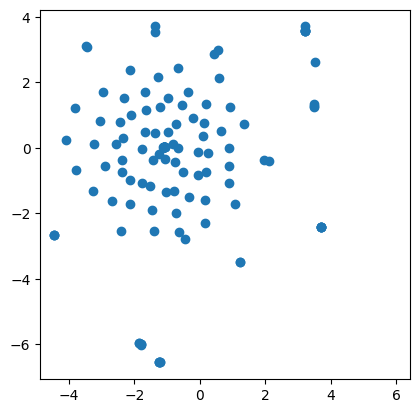

duplicate:16 89
duplicate:16 103
duplicate:89 103
Collisioni: 79
calc MI
MI done


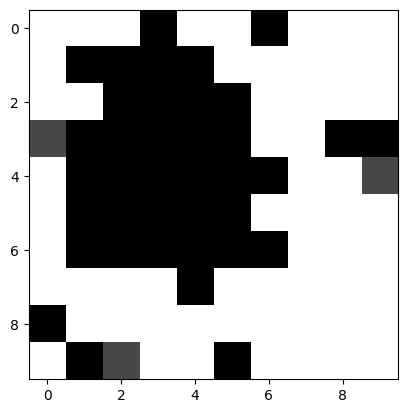

Create images
Preprocessed test data loaded successfully.
Preparing test data for prediction...
Making predictions on test data...
9720/9720 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
Evaluating predictions...
Balanced Accuracy: 95.35%
Confusion Matrix:
[[228705  21731]
 [   381  60212]]

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.91      0.95    250436
      Attack       0.73      0.99      0.84     60593

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029

Generating SHAP explanations...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_19
Received: inputs=['Tensor(shape=(1, 10, 10, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_19
Received: inputs=['Tensor(shape=(50, 10, 10, 1))']
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Detailed Explanation for the Selected Sample:
Predicted Class: Normal
Prediction Probabilities: [[1. 0.]]
Expected Values (Average Prediction): [5.582123e-06 9.999945e-01]


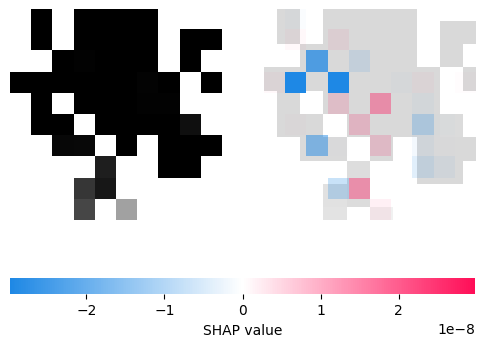


🔹 **Top Positive Contributions:**
 wrong_fragment: 0.2608
Unknown_Pixel_62: 0.1760
 is_guest_login: 0.1225
 dst_bytes: 0.1054
Unknown_Pixel_70: 0.1007
Unknown_Pixel_124: 0.0710
Unknown_Pixel_112: 0.0556
Unknown_Pixel_48: 0.0548
Unknown_Pixel_88: 0.0454
Unknown_Pixel_168: 0.0427

🔹 **Top Negative Contributions:**
Unknown_Pixel_67: -0.2608
Unknown_Pixel_63: -0.1760
Unknown_Pixel_65: -0.1225
 diff_srv_rate: -0.1054
Unknown_Pixel_71: -0.1007
Unknown_Pixel_125: -0.0710
Unknown_Pixel_113: -0.0556
Unknown_Pixel_49: -0.0548
Unknown_Pixel_89: -0.0454
Unknown_Pixel_169: -0.0427


Force plot saved at: /content/IDS/force_plot.html


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
import shap
import matplotlib.pyplot as plt

# Parameters
param = {
    "Max_A_Size": 10,
    "Max_B_Size": 10,
    "Dynamic_Size": False,
    'Metod': 'tSNE',
    "ValidRatio": 0.1,
    "seed": 180,
    "dir": "/content/IDS/Datasets/",  # Directory for input files
    "res": "/content/IDS/Results/",  # Directory for output results
    "Mode": "CNN2",  # Model type
    "LoadFromJson": True,  # Whether to load preprocessed images
    "mutual_info": True,  # Method: Mutual Information (True) or Mean (False)
    "hyper_opt_evals": 20,
    "epoch": 150,
    "No_0_MI": False,  # Whether to remove features with 0 MI
    "autoencoder": False,
    "cut": None,
    "enhanced_dataset": None  # Options: 'gan', 'smote', 'adasyn', None
}

# Set paths
best_model_path = "/content/IDS/Datasets/NSL_KDD/best_model.keras"  # Path to the trained model
test_pickle_path = param["dir"] + f'test_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{"MI" if param["mutual_info"] else "Mean"}.pickle'
test_labels_path = param["dir"] + "YTest.pickle"

# Load Model
print("Loading trained model...")
model = load_model(best_model_path)
print("Model loaded successfully.")

# Check for preprocessed test data
try:
    print("Attempting to load preprocessed test data...")
    with open(test_pickle_path, 'rb') as f:
        XTestGlobal = pickle.load(f)
    with open(test_labels_path, 'rb') as f:
        YTestGlobal = pd.read_pickle(f)
    XTestGlobal = np.array(XTestGlobal)

    test_csv_path = param["dir"] + "Test.csv"
    test_data = pd.read_csv(test_csv_path)
    test_data.replace("", np.nan, inplace=True)
    test_data.dropna(inplace=True)

    XTestGlobal_raw = test_data.values

    # Normalize if needed
    print("Normalizing test data...")
    test_max, test_min = XTestGlobal_raw.max(), XTestGlobal_raw.min()
    XTestGlobal_raw = (XTestGlobal_raw - test_min) / (test_max - test_min)
    _, image_model, toDelete = Cart2Pixel(
        {"data": XTestGlobal_raw.T, "method": param["Metod"], "max_A_size": param["Max_A_Size"], "max_B_size": param["Max_B_Size"], "y": YTestGlobal.values},
        param["Max_A_Size"],
        param["Max_B_Size"],
        param["Dynamic_Size"],
        mutual_info=param["mutual_info"],
        params=param
    )
    print("Preprocessed test data loaded successfully.")
except FileNotFoundError:

    print("Preprocessed test data not found. Regenerating from raw test.csv...")

    # Load raw test data
    test_csv_path = param["dir"] + "Test.csv"
    test_data = pd.read_csv(test_csv_path)
    test_data.replace("", np.nan, inplace=True)
    test_data.dropna(inplace=True)

    # Extract labels and features
    YTestGlobal = test_data[" classification."].astype(int)
    del test_data[" classification."]
    XTestGlobal_raw = test_data.values

    # Normalize if needed
    print("Normalizing test data...")
    test_max, test_min = XTestGlobal_raw.max(), XTestGlobal_raw.min()
    XTestGlobal_raw = (XTestGlobal_raw - test_min) / (test_max - test_min)

    # Reshape using Cart2Pixel or ConvPixel
    print("Generating 2D images from raw test data...")
    # Assuming `Cart2Pixel` function is defined elsewhere
    # Example: Replace with your actual implementation
    _, image_model, toDelete = Cart2Pixel(
        {"data": XTestGlobal_raw.T, "method": param["Metod"], "max_A_size": param["Max_A_Size"], "max_B_size": param["Max_B_Size"]},
        param["Max_A_Size"],
        param["Max_B_Size"],
        param["Dynamic_Size"],
        mutual_info=param["mutual_info"],
        params=param
    )

    XTestGlobal = [
        ConvPixel(
            XTestGlobal_raw[:, i],
            np.array(image_model["xp"]),
            np.array(image_model["yp"]),
            image_model["A"],
            image_model["B"],
            custom_cut=image_model["custom_cut"] if image_model["custom_cut"] else None
        ) for i in range(XTestGlobal_raw.shape[1])
    ]
    XTestGlobal = np.array(XTestGlobal)

    # Save preprocessed test data for future use
    print("Saving preprocessed test data...")
    with open(test_pickle_path, 'wb') as f:
        pickle.dump(XTestGlobal, f)
    with open(test_labels_path, 'wb') as f:
        pickle.dump(YTestGlobal, f)

# Reshape test data for the model
print("Preparing test data for prediction...")

image_size1, image_size2 = XTestGlobal.shape[1], XTestGlobal.shape[2]
XTestGlobal = np.reshape(XTestGlobal, (-1, image_size1, image_size2, 1))

# Predict using the trained model
print("Making predictions on test data...")
Y_predicted_probs = model.predict(XTestGlobal, verbose=1)
Y_predicted = np.argmax(Y_predicted_probs, axis=1)

# Evaluate the results
print("Evaluating predictions...")
accuracy = balanced_accuracy_score(YTestGlobal, Y_predicted)
conf_matrix = confusion_matrix(YTestGlobal, Y_predicted)
print(f"Balanced Accuracy: {accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{conf_matrix}")

report = classification_report(YTestGlobal, Y_predicted, target_names=["Normal", "Attack"])

print("\nClassification Report:\n", report)

# Create a SHAP explainer for the CNN model
# explainer_image = shap.Explainer(model, XTestGlobal)

# # Generate SHAP values
# shap_values_image = explainer_image(XTestGlobal)

# # Visualize SHAP summary
# Create a SHAP explainer for the CNN model
print("Generating SHAP explanations...")
# background = XTestGlobal.mean(axis=0, keepdims=True)  # Use mean as the background
# explainer_image = shap.GradientExplainer(model, background)

# # Select a sample
# sample_index = np.random.choice(len(XTestGlobal), 1, replace=False)[0]
# X_sample = XTestGlobal[sample_index:sample_index + 1]

# # Predict the class for the selected sample
# sample_pred_probs = model.predict(X_sample)[0]
# sample_pred_class = np.argmax(sample_pred_probs)

# # Generate SHAP values
# shap_values_image = explainer_image.shap_values(X_sample)

# # Check SHAP values structure
# if isinstance(shap_values_image, list) and len(shap_values_image) > 1:
#     class_shap_values = shap_values_image[sample_pred_class]
# else:
#     class_shap_values = shap_values_image[0]  # For single-class or regression

# class_shap_values = np.reshape(class_shap_values, X_sample.shape)


# # Display prediction and SHAP explanation
# print("\nDetailed Explanation for the Selected Sample:")
# print(f"Predicted Class: {'Normal' if sample_pred_class == 0 else 'Attack'}")
# print(f"Prediction Probabilities: {sample_pred_probs}")
# print(f"Baseline Prediction (Background Average): {baseline_pred}")

# # Visualize SHAP explanation
# print(f"\nSHAP Explanation for Sample {sample_index} (Predicted Class: {sample_pred_class}):")
# shap.image_plot([class_shap_values], X_sample)

# # Generate force plot
# shap.initjs()
# force_plot_path = "/content/IDS/force_plot.html"

# # Flatten SHAP values for the force plot
# flattened_features = X_sample.flatten()
# flattened_shap_values = class_shap_values.flatten()

# if flattened_features.shape != flattened_shap_values.shape:
#     raise ValueError(
#         f"Shape mismatch: features={flattened_features.shape}, shap_values={flattened_shap_values.shape}"
#     )

# # Generate force plot and save as HTML
# shap.save_html(
#     force_plot_path,
#     shap.force_plot(
#         sample_pred_probs[sample_pred_class],
#         flattened_shap_values,
#         flattened_features,
#         feature_names=[f"Pixel_{i}" for i in range(flattened_features.size)],
#         matplotlib=True
#     )
# )

# print(f"Force plot saved at: {force_plot_path}")

background = XTestGlobal[:100]  # Use the first 100 samples as the background
explainer_image = shap.GradientExplainer(model, background)

# Select a random sample for detailed explanation
random_idx = np.random.choice(XTestGlobal.shape[0], 1, replace=False)
X_sample = XTestGlobal[random_idx]
sample_pred_probs = Y_predicted_probs[random_idx]

sample_pred_class = Y_predicted[random_idx][0]


# Generate SHAP values
shap_values_image = explainer_image.shap_values(X_sample)

# sample_pred_class = np.clip(sample_pred_class, 0, len(shap_values_image) - 1)

# Compute expected values manually (average prediction over the background dataset)
expected_values = np.mean(model.predict(background), axis=0)

# Print detailed explanation for the selected sample
print("\nDetailed Explanation for the Selected Sample:")
print(f"Predicted Class: {'Normal' if sample_pred_class == 0 else 'Attack'}")
print(f"Prediction Probabilities: {sample_pred_probs}")
print(f"Expected Values (Average Prediction): {expected_values}")

# Visualize SHAP explanation
shap.image_plot(shap_values_image, X_sample)

positive_contributions = []
negative_contributions = []

shap_values_flat = shap_values_image[0].flatten()

# Load feature mapping (xp, yp corresponds to original features)
feature_mapping = {}  # Dict to store pixel index → feature name mapping
for feature_idx, (x, y) in enumerate(zip(image_model["xp"], image_model["yp"])):
    pixel_index = (int(y) - 1) * param["Max_A_Size"] + (int(x) - 1)
    if feature_idx < len(test_data.columns):  # Ensure valid feature index
        feature_mapping[pixel_index] = test_data.columns[feature_idx]
    else:
        feature_mapping[pixel_index] = f"Unmapped_Pixel_{pixel_index}"  # Placeholder


# Iterate over SHAP values
for i, value in enumerate(shap_values_flat):
    feature_name = feature_mapping[i] if i in feature_mapping else f"Unknown_Pixel_{i}"  # Get feature name or fallback to Pixel_X
    if value > 0:
        positive_contributions.append((feature_name, value))
    else:
        negative_contributions.append((feature_name, value))

# Sort and print top contributions
positive_contributions = sorted(positive_contributions, key=lambda x: x[1], reverse=True)
negative_contributions = sorted(negative_contributions, key=lambda x: x[1])

print("\n🔹 **Top Positive Contributions:**")
for feature, value in positive_contributions[:10]:
    print(f"{feature}: {value:.4f}")

print("\n🔹 **Top Negative Contributions:**")
for feature, value in negative_contributions[:10]:
    print(f"{feature}: {value:.4f}")


# Generate a summary force plot using SHAP (manually compute contributions)
shap.initjs()
force_plot_path = "/content/IDS/force_plot.html"

# shap_values_for_class = shap_values_image[sample_pred_class]
shap_values_for_class = shap_values_image[0, :, :, :, sample_pred_class]  # Accessing the correct class SHAP values
shap_values_for_class = shap_values_for_class.reshape(1, -1) # Reshape SHAP values to 2D

# Reshape X_sample to 2D to match SHAP values
X_sample_reshaped = X_sample.reshape(1, -1)

shap.save_html(
    force_plot_path,
    shap.force_plot(
        expected_values[sample_pred_class],  # Use the expected value for the predicted class
        shap_values_for_class[0],  # Use the first sample's SHAP values for the class
        X_sample_reshaped[0],  # Flattened input for visualization
        feature_names=["Pixel_" + str(i) for i in range(X_sample[0].size)]
    )
)

print(f"Force plot saved at: {force_plot_path}")

XAI Multiclass


Loading trained model...
Model loaded successfully.
Loading test data...
Loading image model for feature mapping...
Image model loaded successfully
Making predictions...
705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

🔹 Overall Performance Metrics:
Balanced Accuracy: 55.56%
Confusion Matrix:
[[8789   59  815   33   15]
 [2016 5415   29    0    0]
 [ 147  145 1997  131    1]
 [2013    1   26  844    1]
 [  57    1    3    4    2]]

🔹 Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      0.91      0.77      9711
         DoS       0.96      0.73      0.83      7460
       Probe       0.70      0.82      0.75      2421
         R2L       0.83      0.29      0.43      2885
         U2R       0.11      0.03      0.05        67

    accuracy                           0.76     22544
   macro avg       0.65      0.56      0.57     22544
weighted avg       0.79      0.76      0.74     22544


🔹 Generating SHAP explanations...

🔹 Sample #6894:
True 

d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_19
Received: inputs=['Tensor(shape=(1, 10, 10, 1))']
  warnings.warn(msg)
d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_19
Received: inputs=['Tensor(shape=(50, 10, 10, 1))']
  warnings.warn(msg)



🔹 Debugging SHAP value structure:
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1, 10, 10, 1, 5)
⚠️ SHAP values don't have expected structure for class-specific analysis
Falling back to Class Activation Mapping...

🔹 Using Class Activation Mapping (CAM) instead of SHAP:
CAM directly analyzes the CNN's attention to different parts of the input.

🔹 Generating CAM for class: Normal


d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_19']]
Received: inputs=Tensor(shape=(1, 10, 10, 1))
  warnings.warn(msg)



🔹 Generating CAM for class: DoS

🔹 Generating CAM for class: Probe

🔹 Generating CAM for class: R2L

🔹 Generating CAM for class: U2R


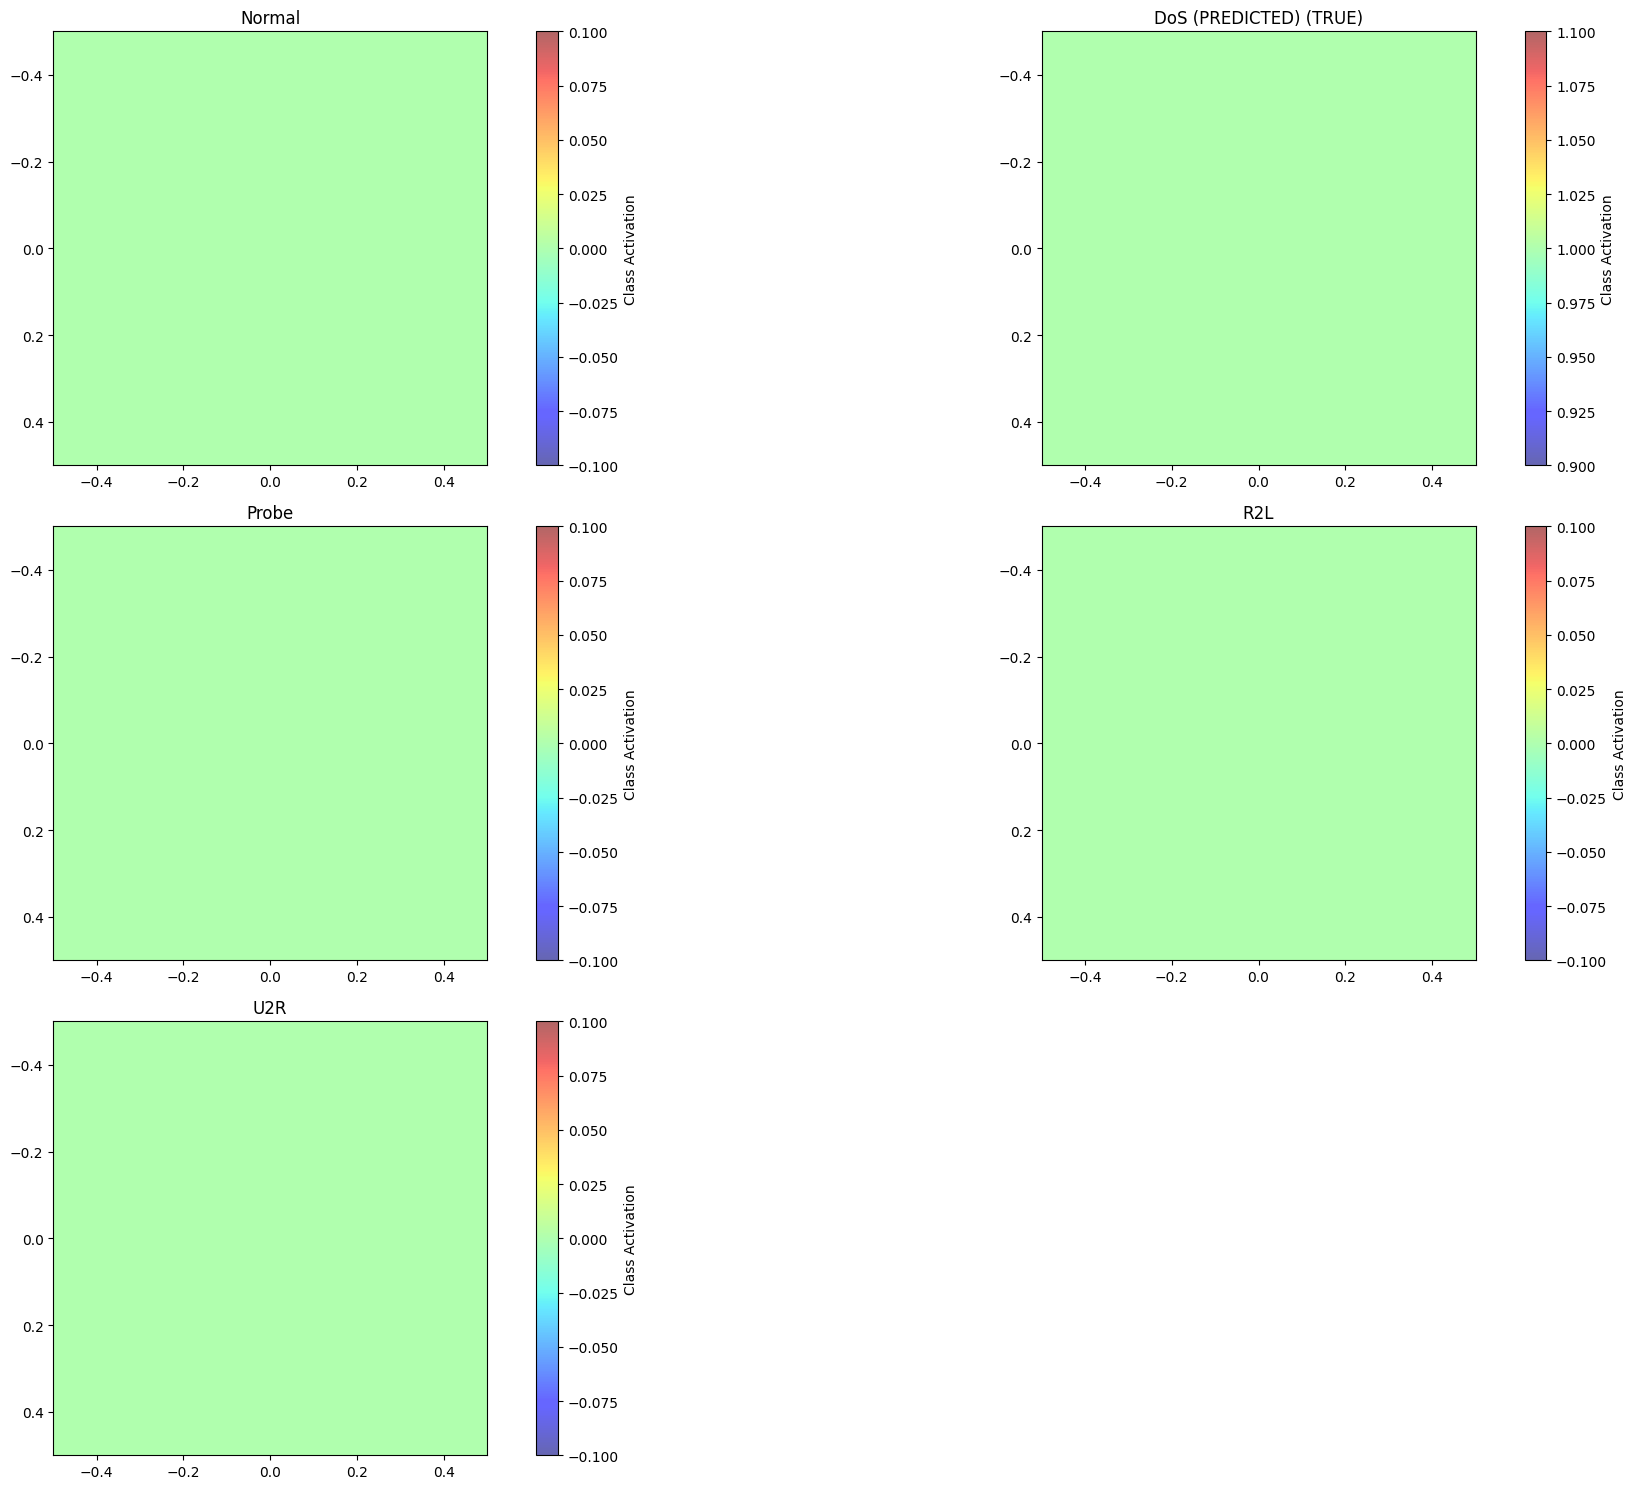


No significant features found for Normal

🔹 Top Features for DoS:
1. duration: 1.0000 - Length of the connection in seconds

No significant features found for Probe

No significant features found for R2L

No significant features found for U2R


In [7]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.patches as mpatches

# Step 1: Define NSL-KDD feature names
def get_nsl_kdd_feature_names():
    """Return the list of feature names for the NSL-KDD dataset"""
    return [
        "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
        "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
        "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
        "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
        "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
        "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
    ]

# Feature descriptions for network security context
def get_feature_descriptions():
    """Return descriptions of the NSL-KDD features in a network security context"""
    return {
        "duration": "Length of the connection in seconds",
        "protocol_type": "Type of protocol (e.g., tcp, udp, icmp)",
        "service": "Network service on destination (e.g., http, ftp)",
        "flag": "Normal or error status of the connection",
        "src_bytes": "Bytes sent from source to destination",
        "dst_bytes": "Bytes sent from destination to source",
        "land": "1 if connection is from/to same host/port; 0 otherwise",
        "wrong_fragment": "Number of 'wrong' fragments",
        "urgent": "Number of urgent packets",
        "hot": "Number of 'hot' indicators (sensitive actions like accessing system files)",
        "num_failed_logins": "Number of failed login attempts",
        "logged_in": "1 if successfully logged in; 0 otherwise",
        "num_compromised": "Number of 'compromised' conditions",
        "root_shell": "1 if root shell is obtained; 0 otherwise",
        "su_attempted": "1 if 'su root' command attempted; 0 otherwise",
        "num_root": "Number of 'root' accesses",
        "num_file_creations": "Number of file creation operations",
        "num_shells": "Number of shell prompts",
        "num_access_files": "Number of sensitive file access operations",
        "num_outbound_cmds": "Number of outbound commands in an ftp session",
        "is_host_login": "1 if the login belongs to the 'hot' list; 0 otherwise",
        "is_guest_login": "1 if the login is a 'guest' login; 0 otherwise",
        "count": "Number of connections to the same host in past 2 seconds",
        "srv_count": "Number of connections to the same service in past 2 seconds",
        "serror_rate": "% of connections with SYN errors",
        "srv_serror_rate": "% of connections with SYN errors to the same service",
        "rerror_rate": "% of connections with REJ errors",
        "srv_rerror_rate": "% of connections with REJ errors to the same service",
        "same_srv_rate": "% of connections to the same service",
        "diff_srv_rate": "% of connections to different services",
        "srv_diff_host_rate": "% of connections to different hosts",
        "dst_host_count": "Count of connections to same destination host",
        "dst_host_srv_count": "Count of connections to same destination host service",
        "dst_host_same_srv_rate": "% of connections to same destination host service",
        "dst_host_diff_srv_rate": "% of connections to different destination host services",
        "dst_host_same_src_port_rate": "% of connections from same source port",
        "dst_host_srv_diff_host_rate": "% of connections to same service from different hosts",
        "dst_host_serror_rate": "% of SYN error connections to destination host",
        "dst_host_srv_serror_rate": "% of SYN error connections to destination host service",
        "dst_host_rerror_rate": "% of REJ error connections to destination host",
        "dst_host_srv_rerror_rate": "% of REJ error connections to destination host service"
    }

# Step 2: Update image model with feature names function
def update_image_model_with_features(image_model_path, param, feature_names=None):
    """Update image model with feature names if they are missing"""
    
    # Use NSL-KDD features if not provided
    if feature_names is None:
        feature_names = get_nsl_kdd_feature_names()
    
    # Load existing image model if available
    if os.path.exists(image_model_path):
        with open(image_model_path, 'rb') as f:
            image_model = pickle.load(f)
    else:
        # Create a basic image model structure
        image_model = {
            "xp": None,
            "yp": None,
            "A": param["Max_A_Size"],
            "B": param["Max_B_Size"],
            "custom_cut": None
        }
    
    # Add or update feature mapping
    if 'feature_mapping' not in image_model:
        image_model['feature_mapping'] = {
            'pixel_mapping': {},
            'feature_names': feature_names
        }
        
        # Create basic pixel mapping based on Cart2Pixel transformation
        for feature_idx, feature_name in enumerate(feature_names):
            if feature_idx < param["Max_A_Size"] * param["Max_B_Size"]:
                x = feature_idx % param["Max_A_Size"]
                y = feature_idx // param["Max_A_Size"]
                pixel_idx = y * param["Max_A_Size"] + x
                
                image_model['feature_mapping']['pixel_mapping'][str(pixel_idx)] = {
                    'feature_name': feature_name,
                    'x_coord': x + 1,
                    'y_coord': y + 1
                }
    
    # Save updated image model
    with open(image_model_path, 'wb') as f:
        pickle.dump(image_model, f)
    
    return image_model

# Define attack characteristics for better explanations
def get_attack_characteristics():
    """Return characteristics of different attack types"""
    return {
        "Normal": "Regular, benign network traffic with expected patterns and behaviors.",
        "DoS": "Denial of Service attacks attempt to make a network resource unavailable by flooding it with traffic or making it crash. Characterized by high volume of traffic to specific services.",
        "Probe": "Scanning and probing attacks attempt to gather information about the network to identify vulnerabilities. Characterized by connections to many ports/services in short time.",
        "R2L": "Remote to Local attacks attempt to gain unauthorized access from a remote machine. Characterized by unusual access patterns and credential manipulation.",
        "U2R": "User to Root attacks attempt to gain root/admin privileges. Characterized by privilege escalation actions after gaining normal user access."
    }

# Alternative: Class Activation Mapping function
def generate_class_activation_maps(model, X_sample, class_idx):
    """Generate Class Activation Maps to explain CNN predictions"""
    import tensorflow as tf
    
    # Create a model that outputs both the predictions and the last convolutional layer's activations
    last_conv_layer = None
    # Find the last convolutional layer
    for layer in model.layers[::-1]:
        if 'conv' in layer.name.lower():
            last_conv_layer = layer.name
            break
    
    if last_conv_layer is None:
        print("Could not find a convolutional layer")
        return None
    
    # Get the model's weights for the final dense layer
    final_dense_layer = model.layers[-1]
    weights = final_dense_layer.get_weights()[0]
    
    # Create a model that will return the last conv layer's output
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer).output, model.output]
    )
    
    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Cast input to float32
        X_sample_float = tf.cast(X_sample, tf.float32)
        # Get conv_output and predictions
        conv_output, predictions = grad_model(X_sample_float)
        # Get the prediction for the specific class
        class_prediction = predictions[:, class_idx]
    
    # Get the gradients of the class output with respect to the conv output
    grads = tape.gradient(class_prediction, conv_output)
    
    # Get the mean gradients over all the batch samples
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply the convolutional outputs by the importance of each filter
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    return heatmap

# Function to visualize the CAM and map back to original features
def visualize_cam(model, X_sample, y_pred, y_true, image_model, attack_categories, output_dir=None):
    """Visualize Class Activation Maps for each class and map to original features"""
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    
    # Get feature descriptions
    feature_descriptions = get_feature_descriptions()
    
    # Create figure for multiple class visualizations
    plt.figure(figsize=(20, 15))
    
    # Process each class
    num_classes = len(attack_categories)
    class_features = {}
    
    for class_idx, class_name in enumerate(attack_categories):
        print(f"\n🔹 Generating CAM for class: {class_name}")
        
        # Generate the CAM for this class
        heatmap = generate_class_activation_maps(model, X_sample, class_idx)
        
        if heatmap is None:
            print(f"Could not generate CAM for class {class_name}")
            continue
        
        # Create subplot for this class
        plt.subplot(3, 2, class_idx + 1)
        
        # Show the original image
        plt.imshow(X_sample[0, :, :, 0], cmap='gray', alpha=0.8)
        
        # Overlay the heatmap
        plt.imshow(heatmap, cmap='jet', alpha=0.6)
        
        # Add title
        title = f"{class_name}"
        if class_idx == y_pred:
            title += " (PREDICTED)"
        if class_idx == y_true:
            title += " (TRUE)"
        plt.title(title)
        
        plt.colorbar(label='Class Activation')
        
        # Map the important regions back to original features
        feature_importance = {}
        for y in range(heatmap.shape[0]):
            for x in range(heatmap.shape[1]):
                pixel_idx = y * heatmap.shape[1] + x
                pixel_key = str(pixel_idx)
                
                if pixel_key in image_model['feature_mapping']['pixel_mapping']:
                    feature_info = image_model['feature_mapping']['pixel_mapping'][pixel_key]
                    feature_name = feature_info['feature_name']
                    
                    importance = heatmap[y, x]
                    if importance > 0.1:  # Only consider significant activations
                        if feature_name not in feature_importance:
                            feature_importance[feature_name] = importance
                        else:
                            feature_importance[feature_name] = max(feature_importance[feature_name], importance)
        
        # Sort features by importance
        sorted_features = sorted(
            feature_importance.items(),
            key=lambda x: x[1],
            reverse=True
        )[:15]  # Top 15 features
        
        class_features[class_name] = sorted_features
    
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'class_activation_maps.png'))
    
    plt.show()
    
    # Display feature importance for each class
    for class_name, features in class_features.items():
        if not features:
            print(f"\nNo significant features found for {class_name}")
            continue
        
        print(f"\n🔹 Top Features for {class_name}:")
        for i, (feature_name, importance) in enumerate(features):
            desc = feature_descriptions.get(feature_name, "No description available")
            print(f"{i+1}. {feature_name}: {importance:.4f} - {desc}")
    
    return class_features

# Step 3: Main explanation function
def explain_multi_class_prediction(model_path, test_data_path, test_labels_path, image_model_path=None, 
                                  num_features=15, output_dir=None, sample_idx=None, explain_all_classes=True):
    """
    Generate explanations for multi-class intrusion detection predictions.
    
    Parameters:
    -----------
    model_path : str
        Path to the trained model file
    test_data_path : str
        Path to the test data pickle file
    test_labels_path : str
        Path to the test labels pickle file
    image_model_path : str, optional
        Path to the image model pickle file (for feature mapping)
    num_features : int, default=15
        Number of top features to display
    output_dir : str, optional
        Directory to save output files
    sample_idx : int, optional
        Index of specific sample to explain (random if None)
    explain_all_classes : bool, default=True
        Whether to explain all classes or just the predicted and true classes
    
    Returns:
    --------
    dict
        Dictionary containing explanation results
    """
    # Attack category names and characteristics
    attack_categories = ["Normal", "DoS", "Probe", "R2L", "U2R"]
    attack_chars = get_attack_characteristics()
    feature_descriptions = get_feature_descriptions()
    
    # Load model
    print("Loading trained model...")
    model = load_model(model_path)
    print("Model loaded successfully.")
    
    # Load test data
    print("Loading test data...")
    with open(test_data_path, 'rb') as f:
        XTestGlobal = pickle.load(f)
    with open(test_labels_path, 'rb') as f:
        YTestGlobal = pd.read_pickle(f)
    
    # Convert to numpy array if needed
    XTestGlobal = np.array(XTestGlobal)
    
    # Try to load image_model for feature mapping
    if image_model_path and os.path.exists(image_model_path):
        print("Loading image model for feature mapping...")
        with open(image_model_path, 'rb') as f:
            image_model = pickle.load(f)
        print("Image model loaded successfully")
    else:
        print("Image model not found. Creating default feature mapping...")
        image_model = None
    
    # Reshape test data for the model
    image_size1, image_size2 = XTestGlobal.shape[1], XTestGlobal.shape[2]
    XTestGlobal_reshaped = np.reshape(XTestGlobal, (-1, image_size1, image_size2, 1))
    
    # Make predictions
    print("Making predictions...")
    Y_predicted_probs = model.predict(XTestGlobal_reshaped, verbose=1)
    Y_predicted = np.argmax(Y_predicted_probs, axis=1)
    
    # Display overall performance metrics
    print("\n🔹 Overall Performance Metrics:")
    accuracy = balanced_accuracy_score(YTestGlobal, Y_predicted)
    conf_matrix = confusion_matrix(YTestGlobal, Y_predicted)
    print(f"Balanced Accuracy: {accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Display classification report
    print("\n🔹 Classification Report:")
    report = classification_report(YTestGlobal, Y_predicted, target_names=attack_categories)
    print(report)
    
    # Feature Mapping Preparation
    # If no image_model is available, create a default mapping
    if image_model is None:
        # Use the helper function to get feature names
        original_features = get_nsl_kdd_feature_names()
        
        # Create default image_model with feature mapping
        image_model = {
            "xp": None,
            "yp": None,
            "A": image_size1,
            "B": image_size2,
            "custom_cut": None,
            "feature_mapping": {
                'pixel_mapping': {},
                'feature_names': original_features[:image_size1 * image_size2]
            }
        }
        
        # Create pixel mapping
        for i in range(min(len(original_features), image_size1 * image_size2)):
            x = i % image_size1
            y = i // image_size1
            pixel_idx = y * image_size1 + x
            image_model['feature_mapping']['pixel_mapping'][str(pixel_idx)] = {
                'feature_name': original_features[i],
                'x_coord': x + 1,
                'y_coord': y + 1
            }
    
    # SHAP Analysis
    print("\n🔹 Generating SHAP explanations...")
    
    # Use a subset of data as background for the explainer
    background = XTestGlobal_reshaped[:30]  # Reduced from 50 to 30 samples to save memory
    
    # Select sample to explain (random if not specified)
    if sample_idx is None:
        sample_idx = np.random.choice(XTestGlobal_reshaped.shape[0])
    
    X_sample = XTestGlobal_reshaped[sample_idx:sample_idx+1]
    y_true = YTestGlobal[sample_idx]
    y_pred = Y_predicted[sample_idx]
    
    # Get prediction probabilities
    pred_probs = Y_predicted_probs[sample_idx]
    
    # Basic info about the sample
    print(f"\n🔹 Sample #{sample_idx}:")
    print(f"True Class: {attack_categories[y_true]}")
    print(f"Predicted Class: {attack_categories[y_pred]}")
    print("Prediction Probabilities:")
    for i, category in enumerate(attack_categories):
        print(f"  {category}: {pred_probs[i]:.4f}")
    
    # Print classification context
    print("\n🔹 Classification Context:")
    if y_true == y_pred:
        print(f"✅ This sample was correctly classified as {attack_categories[y_pred]}.")
        print(f"Description: {attack_chars[attack_categories[y_pred]]}")
    else:
        print(f"❌ This sample was misclassified as {attack_categories[y_pred]} when it was actually {attack_categories[y_true]}.")
        print(f"True class ({attack_categories[y_true]}): {attack_chars[attack_categories[y_true]]}")
        print(f"Predicted class ({attack_categories[y_pred]}): {attack_chars[attack_categories[y_pred]]}")
    
    try:
        # Try SHAP approach first
        shap_succeeded = False
        
        try:
            # Create explainer with fewer background samples
            explainer = shap.GradientExplainer(model, background)
            
            # Generate SHAP values for the sample - with error handling
            print("Calculating SHAP values...")
            shap_values = explainer.shap_values(X_sample)
            
            # Debug SHAP values structure
            print("\n🔹 Debugging SHAP value structure:")
            print(f"SHAP values type: {type(shap_values)}")
            if isinstance(shap_values, list):
                print(f"SHAP values list length: {len(shap_values)}")
                for i, sv in enumerate(shap_values):
                    print(f"  Class {i} shape: {np.array(sv).shape}")
            else:
                print(f"SHAP values shape: {np.array(shap_values).shape}")
            
            # Check if we have class-specific SHAP values
            if isinstance(shap_values, list) and len(shap_values) == len(attack_categories):
                shap_succeeded = True
                print("✅ Successfully obtained class-specific SHAP values")
            else:
                print("⚠️ SHAP values don't have expected structure for class-specific analysis")
                print("Falling back to Class Activation Mapping...")
        except Exception as shap_error:
            print(f"⚠️ Error generating SHAP values: {shap_error}")
            print("Falling back to Class Activation Mapping...")
        
        if shap_succeeded:
            # Create a function to analyze SHAP values for a specific class
            def analyze_class_shap(class_idx, class_name, is_predicted=False, is_true=False):
                status = ""
                if is_predicted and is_true:
                    status = "🟢 PREDICTED & TRUE CLASS"
                elif is_predicted:
                    status = "🟡 PREDICTED CLASS"
                elif is_true:
                    status = "🔵 TRUE CLASS"
                    
                print(f"\n🔹 SHAP Analysis for Class: {class_name} {status}")
                print(f"Description: {attack_chars[class_name]}")
                
                # Extract SHAP values for the specified class - IMPROVED CODE
                print(f"Extracting SHAP values for class {class_name} (index {class_idx})")
                
                if isinstance(shap_values, list) and len(shap_values) > class_idx:
                    # Case 1: List of arrays (one per class) - standard SHAP output format
                    class_shap_values = shap_values[class_idx]
                elif isinstance(shap_values, np.ndarray) and shap_values.ndim >= 4:
                    # Case 2: Single array with class dimension - common with Gradient Explainer
                    # Shape is typically (samples, height, width, channels, num_classes)
                    # For a single sample: (1, height, width, channels, num_classes)
                    # We need to extract the specific class values
                    print(f"Multi-dimensional array with shape {shap_values.shape}")
                    if shap_values.shape[-1] > class_idx:
                        # Extract values for this specific class
                        class_shap_values = shap_values[..., class_idx]
                        print(f"Extracted class {class_idx} values with shape {class_shap_values.shape}")
                    else:
                        print(f"ERROR: Class index {class_idx} out of bounds for SHAP values shape {shap_values.shape}")
                        return None
                else:
                    # Case 3: Binary classification or other format
                    print("Using entire SHAP values array (possibly binary classification)")
                    class_shap_values = shap_values
                
                # Flatten for processing
                flat_shap_values = class_shap_values.flatten()
                print(f"Flattened SHAP values shape: {flat_shap_values.shape}")
                print(f"SHAP values range: Min={flat_shap_values.min():.5e}, Max={flat_shap_values.max():.5e}")
                print(f"Sample values: {flat_shap_values[:5]}")
                
                # Map pixels to features and aggregate importance
                feature_importance = {}
                
                # Process each pixel's SHAP value
                for pixel_idx, shap_value in enumerate(flat_shap_values):
                    # Skip if value is close to zero (no impact)
                    if abs(shap_value) < 1e-10:
                        continue
                        
                    # Map pixel to feature
                    pixel_key = str(pixel_idx)
                    if pixel_key in image_model['feature_mapping']['pixel_mapping']:
                        feature_info = image_model['feature_mapping']['pixel_mapping'][pixel_key]
                        feature_name = feature_info['feature_name']
                        
                        # Add or update feature importance
                        if feature_name not in feature_importance:
                            feature_importance[feature_name] = {
                                'importance': float(shap_value),
                                'abs_importance': abs(float(shap_value)),
                                'coordinates': (feature_info['x_coord'], feature_info['y_coord']),
                                'type': 'positive' if shap_value > 0 else 'negative'
                            }
                        else:
                            # If multiple pixels map to the same feature, use the one with the highest absolute value
                            if abs(shap_value) > feature_importance[feature_name]['abs_importance']:
                                feature_importance[feature_name]['importance'] = float(shap_value)
                                feature_importance[feature_name]['abs_importance'] = abs(float(shap_value))
                                feature_importance[feature_name]['type'] = 'positive' if shap_value > 0 else 'negative'
                
                # Check if we found any features with importance
                if not feature_importance:
                    print("No significant feature importance values found for this class.")
                    return None
                    
                # Sort features by absolute importance
                sorted_features = sorted(
                    feature_importance.items(),
                    key=lambda x: x[1]['abs_importance'],
                    reverse=True
                )[:num_features]  # Get top N features
                
                # Visualization
                plt.figure(figsize=(18, 8))
                
                # 1. Feature Importance Plot
                plt.subplot(1, 2, 1)
                features = [x[0] for x in sorted_features]
                importance_values = [x[1]['importance'] for x in sorted_features]
                colors = ['red' if x[1]['type'] == 'positive' else 'blue' for x in sorted_features]
                
                # Create horizontal bar plot
                bars = plt.barh(range(len(features)), importance_values, color=colors)
                
                # Only add values to the bars if we have importance values
                if importance_values:
                    max_importance = max([abs(x) for x in importance_values])
                    for i, bar in enumerate(bars):
                        value = importance_values[i]
                        if value > 0:
                            plt.text(value + max_importance * 0.01, i, f"{value:.2e}", va='center')
                        else:
                            plt.text(value - max_importance * 0.05, i, f"{value:.2e}", va='center', ha='right', color='white')
                
                plt.yticks(range(len(features)), [f"{f[:25]}..." if len(f) > 25 else f for f in features])
                plt.xlabel('SHAP Value')
                plt.title(f'Top {num_features} Feature Contributions for {class_name}')
                
                # Add legend
                red_patch = mpatches.Patch(color='red', label='Increases probability')
                blue_patch = mpatches.Patch(color='blue', label='Decreases probability')
                plt.legend(handles=[red_patch, blue_patch], loc='lower right')
                
                # 2. Pixel Location Plot
                plt.subplot(1, 2, 2)
                pixel_values = np.zeros((image_size1, image_size2))
                
                # Fill in pixel values from top features
                for feature_name, details in sorted_features:
                    x, y = details['coordinates']
                    # Ensure coordinates are within bounds and adjust to 0-indexed
                    x = min(x-1, image_size1-1)
                    y = min(y-1, image_size2-1)
                    pixel_values[y, x] = details['importance']  # Note: y, x for array indexing
                
                # Create heatmap
                sns.heatmap(pixel_values, cmap='RdBu_r', center=0)
                plt.title(f'Feature Location Heatmap for {class_name}')
                
                plt.tight_layout()
                
                # Save the figure if output directory is provided
                if output_dir:
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    plt.savefig(os.path.join(output_dir, f'feature_importance_{class_name}.png'))
                
                plt.show()
                
                # Create HTML table for feature importance with enhanced explanations
                table_html = f"""
                <h3>Top {min(num_features, len(sorted_features))} Features for {class_name} Classification {status}</h3>
                <table style="width:100%; border-collapse: collapse; margin-bottom: 20px;">
                    <tr style="background-color: #f2f2f2;">
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Rank</th>
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Feature</th>
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Description</th>
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Importance</th>
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Impact</th>
                    </tr>
                """
                
                for i, (feature_name, details) in enumerate(sorted_features):
                    color = "#ffebee" if details['type'] == 'positive' else "#e3f2fd"
                    impact = "Increases probability" if details['type'] == 'positive' else "Decreases probability"
                    description = feature_descriptions.get(feature_name, "No description available")
                    
                    table_html += f"""
                    <tr style="background-color: {color}">
                        <td style="padding: 12px; border: 1px solid #ddd;">{i+1}</td>
                        <td style="padding: 12px; border: 1px solid #ddd;">{feature_name}</td>
                        <td style="padding: 12px; border: 1px solid #ddd;">{description}</td>
                        <td style="padding: 12px; border: 1px solid #ddd;">{details['abs_importance']:.2e}</td>
                        <td style="padding: 12px; border: 1px solid #ddd;">{impact}</td>
                    </tr>
                    """
                
                table_html += "</table>"
                display(HTML(table_html))
                
                # Provide interpretation of the results
                print("\n🔹 Interpretation:")
                print(f"For {class_name} classification, the model is:")
                
                # Get top 3 positive and negative features if available
                positive_features = [(name, details) for name, details in sorted_features if details['type'] == 'positive']
                negative_features = [(name, details) for name, details in sorted_features if details['type'] == 'negative']
                
                # Sort by absolute importance
                positive_features = sorted(positive_features, key=lambda x: x[1]['abs_importance'], reverse=True)[:3]
                negative_features = sorted(negative_features, key=lambda x: x[1]['abs_importance'], reverse=True)[:3]
                
                if positive_features:
                    print("  Primarily focusing on (increasing probability):")
                    for name, details in positive_features:
                        print(f"    - {name}: {feature_descriptions.get(name, 'No description available')}")
                
                if negative_features:
                    print("  Being discouraged by (decreasing probability):")
                    for name, details in negative_features:
                        print(f"    - {name}: {feature_descriptions.get(name, 'No description available')}")
                
                print(f"\nThis {'' if is_predicted else 'would have '} led to a {class_name} classification.")
                
                # Return the analysis for this class
                return {
                    'class_name': class_name,
                    'shap_values': class_shap_values,
                    'feature_importance': sorted_features,
                    'is_predicted': is_predicted,
                    'is_true': is_true
                }
            
            # Track all class analyses
            class_analyses = {}
            
            # If we're explaining all classes, loop through each attack category
            if explain_all_classes:
                print("\n🔹 Analyzing all attack classes...")
                for class_idx, class_name in enumerate(attack_categories):
                    is_predicted = (class_idx == y_pred)
                    is_true = (class_idx == y_true)
                    
                    class_analyses[class_name] = analyze_class_shap(
                        class_idx, 
                        class_name, 
                        is_predicted=is_predicted, 
                        is_true=is_true
                    )
            else:
                # Otherwise, just analyze the predicted class and true class if different
                print("\n🔹 Analyzing predicted class...")
                class_analyses[attack_categories[y_pred]] = analyze_class_shap(
                    y_pred, 
                    attack_categories[y_pred], 
                    is_predicted=True, 
                    is_true=(y_pred == y_true)
                )
                
                # Optionally, also analyze SHAP values for the true class if different
                if y_true != y_pred:
                    print("\n🔹 Analyzing true class...")
                    class_analyses[attack_categories[y_true]] = analyze_class_shap(
                        y_true, 
                        attack_categories[y_true], 
                        is_predicted=False, 
                        is_true=True
                    )
            
            # Compare significant features across classes
            print("\n🔹 Cross-Class Feature Comparison:")
            all_important_features = set()
            class_feature_importance = {}
            
            for class_name, analysis in class_analyses.items():
                if analysis:  # Check if analysis exists
                    class_feature_importance[class_name] = {}
                    for feature_name, details in analysis['feature_importance']:
                        all_important_features.add(feature_name)
                        class_feature_importance[class_name][feature_name] = details['importance']
            
            # Create comparison table
            comparison_html = """
            <h3>Cross-Class Feature Comparison</h3>
            <p>This table shows how each important feature affects the probability of each attack class.</p>
            <table style="width:100%; border-collapse: collapse; margin-bottom: 20px;">
                <tr style="background-color: #f2f2f2;">
                    <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Feature</th>
            """
            
            # Add class headers
            for class_name in class_feature_importance.keys():
                comparison_html += f'<th style="padding: 12px; text-align: center; border: 1px solid #ddd;">{class_name}</th>'
            
            comparison_html += "</tr>"
            
            # Add feature rows
            for feature in sorted(all_important_features):
                comparison_html += f"""
                <tr>
                    <td style="padding: 12px; border: 1px solid #ddd;">{feature}</td>
                """
                
                for class_name in class_feature_importance.keys():
                    importance = class_feature_importance[class_name].get(feature, 0)
                    if abs(importance) < 1e-10:
                        # Negligible impact
                        cell_style = 'background-color: #f9f9f9; color: #888;'
                        cell_text = "0"
                    elif importance > 0:
                        # Positive impact (increases probability)
                        intensity = min(255, int(255 * (1 - min(1, importance * 100))))
                        cell_style = f'background-color: rgba(255, {intensity}, {intensity}, 0.8);'
                        cell_text = f"+{importance:.2e}"
                    else:
                        # Negative impact (decreases probability)
                        intensity = min(255, int(255 * (1 - min(1, abs(importance) * 100))))
                        cell_style = f'background-color: rgba({intensity}, {intensity}, 255, 0.8);'
                        cell_text = f"{importance:.2e}"
                    
                    comparison_html += f'<td style="padding: 12px; text-align: center; border: 1px solid #ddd; {cell_style}">{cell_text}</td>'
                
                comparison_html += "</tr>"
            
            comparison_html += "</table>"
            display(HTML(comparison_html))
            
            # Print cross-class insights
            print("\n🔹 Cross-Class Insights:")
            
            # Find distinguishing features
            if y_true != y_pred:
                true_class = attack_categories[y_true]
                pred_class = attack_categories[y_pred]
                
                true_class_features = class_feature_importance.get(true_class, {})
                pred_class_features = class_feature_importance.get(pred_class, {})
                
                # Find features that strongly favor the true class but were missed
                distinguishing_features = []
                for feature, true_importance in true_class_features.items():
                    pred_importance = pred_class_features.get(feature, 0)
                    if true_importance > 0 and (true_importance > pred_importance):
                        distinguishing_features.append((feature, true_importance - pred_importance))
                
                # Sort by importance difference
                distinguishing_features.sort(key=lambda x: x[1], reverse=True)
                
                if distinguishing_features:
                    print(f"Features that should have indicated {true_class} but were overlooked:")
                    for feature, diff in distinguishing_features[:3]:  # Top 3
                        print(f"  - {feature}: {feature_descriptions.get(feature, 'No description available')}")
                else:
                    print(f"No clear distinguishing features found that would indicate {true_class} over {pred_class}.")
            
            # Try to show original SHAP image plot for comparison
            try:
                print("\n🔹 Original SHAP Visualization (Pixel Values):")
                shap.image_plot(shap_values, X_sample, show=True)
            except Exception as e:
                print(f"Could not generate SHAP image plot: {e}")
            
            # Return results
            return {
                'sample_idx': sample_idx,
                'y_true': y_true,
                'y_pred': y_pred,
                'pred_probs': pred_probs,
                'class_analyses': class_analyses
            }
        
        else:
            # SHAP approach failed, use Class Activation Mapping instead
            print("\n🔹 Using Class Activation Mapping (CAM) instead of SHAP:")
            print("CAM directly analyzes the CNN's attention to different parts of the input.")
            cam_features = visualize_cam(model, X_sample, y_pred, y_true, image_model, attack_categories, output_dir)
            
            return {
                'sample_idx': sample_idx,
                'y_true': y_true,
                'y_pred': y_pred,
                'pred_probs': pred_probs,
                'cam_features': cam_features,
                'method': 'CAM'
            }
    
    except Exception as e:
        print(f"\n⚠️ Error generating explanations: {e}")
        print("\nFalling back to simplified feature importance analysis...")
        
        # Create a simplified feature importance visualization
        plt.figure(figsize=(14, 6))
        plt.title(f"Sample #{sample_idx}: {attack_categories[y_true]} classified as {attack_categories[y_pred]}")
        plt.imshow(X_sample[0, :, :, 0], cmap='viridis')
        plt.colorbar(label='Feature Value')
        plt.tight_layout()
        plt.show()
        
        # Return basic information
        return {
            'sample_idx': sample_idx,
            'y_true': y_true,
            'y_pred': y_pred,
            'pred_probs': pred_probs,
            'error': str(e)
        }

# Step 4: Configure parameters and execute analysis
# Update these paths to match your environment
param = {
    "Max_A_Size": 10,
    "Max_B_Size": 10,
    "Dynamic_Size": False,
    'Metod': 'tSNE',
    "ValidRatio": 0.1,
    "seed": 180,
    "dir": "D:/IDS/Code/Datasets/NSLKDD/",  # Update with your path
    "res": "D:/IDS/Code/Results/",  # Update with your path
    "Mode": "CNN2",  # CNN_Nature or CNN2
    "LoadFromJson": True,
    "mutual_info": True,
}

# Set paths
model_path = param["dir"] + "best_model.keras"
test_data_path = param["dir"] + f'test_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{"MI" if param["mutual_info"] else "Mean"}.pickle'
test_labels_path = param["dir"] + "Ytest.pickle"
image_model_path = param["dir"] + f'image_model_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{"MI" if param["mutual_info"] else "Mean"}.pickle'
output_dir = param["res"] + "explanations/"

# Update image model with feature names
update_image_model_with_features(image_model_path, param)

# Generate explanations
results = explain_multi_class_prediction(
    model_path=model_path,
    test_data_path=test_data_path,
    test_labels_path=test_labels_path,
    image_model_path=image_model_path,
    num_features=15,
    output_dir=output_dir,
    explain_all_classes=True  # Analyze all classes, not just predicted/true
)

XAI Multiclass Better

Loading trained model...
Model loaded successfully.
Loading test data...
Loading image model for feature mapping...
Image model loaded successfully
Making predictions...
705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

🔹 Overall Performance Metrics:
Balanced Accuracy: 55.56%
Confusion Matrix:
[[8789   59  815   33   15]
 [2016 5415   29    0    0]
 [ 147  145 1997  131    1]
 [2013    1   26  844    1]
 [  57    1    3    4    2]]

🔹 Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      0.91      0.77      9711
         DoS       0.96      0.73      0.83      7460
       Probe       0.70      0.82      0.75      2421
         R2L       0.83      0.29      0.43      2885
         U2R       0.11      0.03      0.05        67

    accuracy                           0.76     22544
   macro avg       0.65      0.56      0.57     22544
weighted avg       0.79      0.76      0.74     22544


🔹 Generating SHAP explanations...

🔹 Sample #12295:
True

d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_19
Received: inputs=['Tensor(shape=(1, 10, 10, 1))']
  warnings.warn(msg)
d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_19
Received: inputs=['Tensor(shape=(50, 10, 10, 1))']
  warnings.warn(msg)



🔹 Debugging SHAP value structure:
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1, 10, 10, 1, 5)
✅ Multi-class SHAP values detected in the last dimension
SHAP values shape: (1, 10, 10, 1, 5)

🔹 SHAP Analysis for Class: Normal 
Description: Regular, benign network traffic with expected patterns and behaviors.
Class SHAP shape after squeezing: (10, 10)


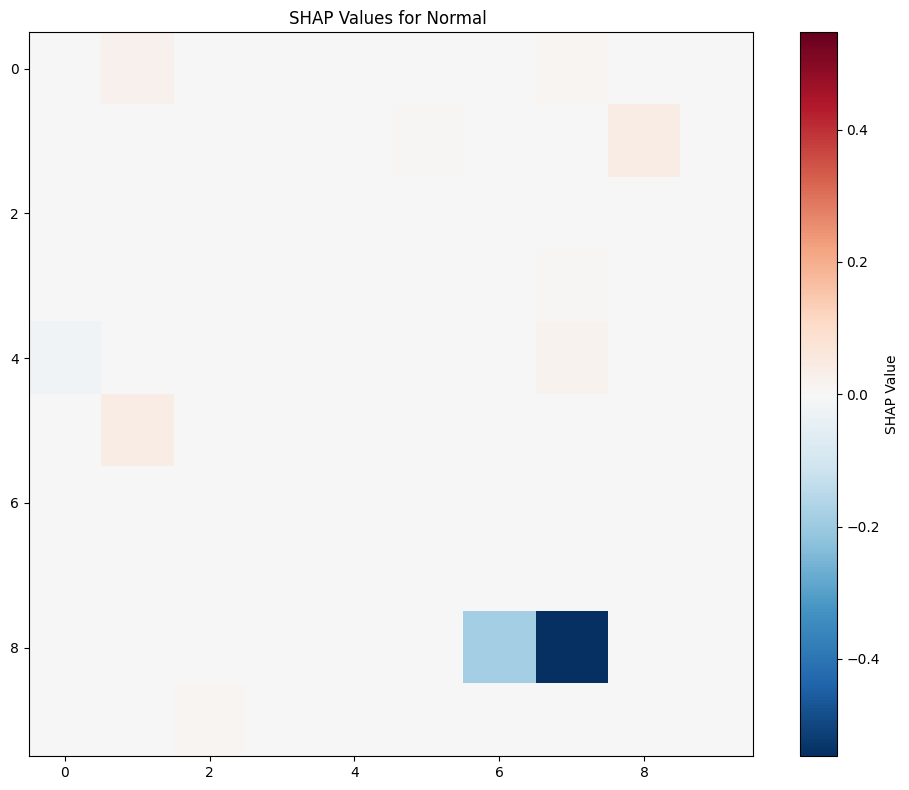

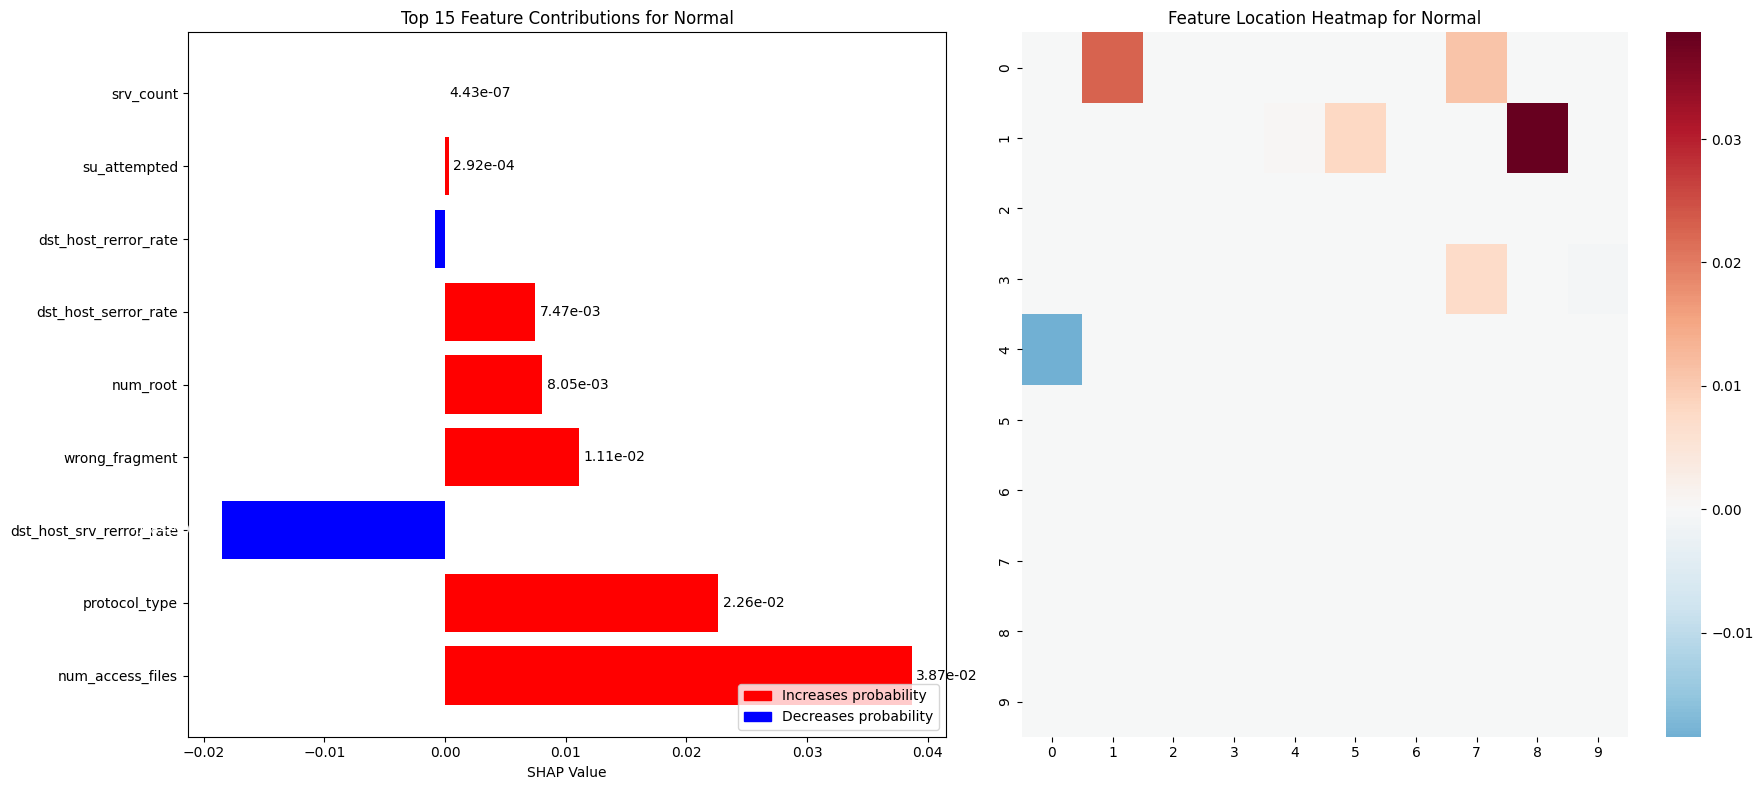

Rank,Feature,Description,Importance,Impact
1,num_access_files,Number of sensitive file access operations,3.87e-02,Increases probability
2,protocol_type,"Type of protocol (e.g., tcp, udp, icmp)",2.26e-02,Increases probability
3,dst_host_srv_rerror_rate,% of REJ error connections to destination host service,1.84e-02,Decreases probability
4,wrong_fragment,Number of 'wrong' fragments,1.11e-02,Increases probability
5,num_root,Number of 'root' accesses,8.05e-03,Increases probability
6,dst_host_serror_rate,% of SYN error connections to destination host,7.47e-03,Increases probability
7,dst_host_rerror_rate,% of REJ error connections to destination host,8.20e-04,Decreases probability
8,su_attempted,1 if 'su root' command attempted; 0 otherwise,2.92e-04,Increases probability
9,srv_count,Number of connections to the same service in past 2 seconds,4.43e-07,Increases probability



🔹 Interpretation:
For Normal classification, the model is:
  Primarily focusing on (increasing probability):
    - num_access_files: Number of sensitive file access operations
    - protocol_type: Type of protocol (e.g., tcp, udp, icmp)
    - wrong_fragment: Number of 'wrong' fragments
  Being discouraged by (decreasing probability):
    - dst_host_srv_rerror_rate: % of REJ error connections to destination host service
    - dst_host_rerror_rate: % of REJ error connections to destination host

This would have  led to a Normal classification.

🔹 SHAP Analysis for Class: DoS 
Description: Denial of Service attacks attempt to make a network resource unavailable by flooding it with traffic or making it crash. Characterized by high volume of traffic to specific services.
Class SHAP shape after squeezing: (10, 10)


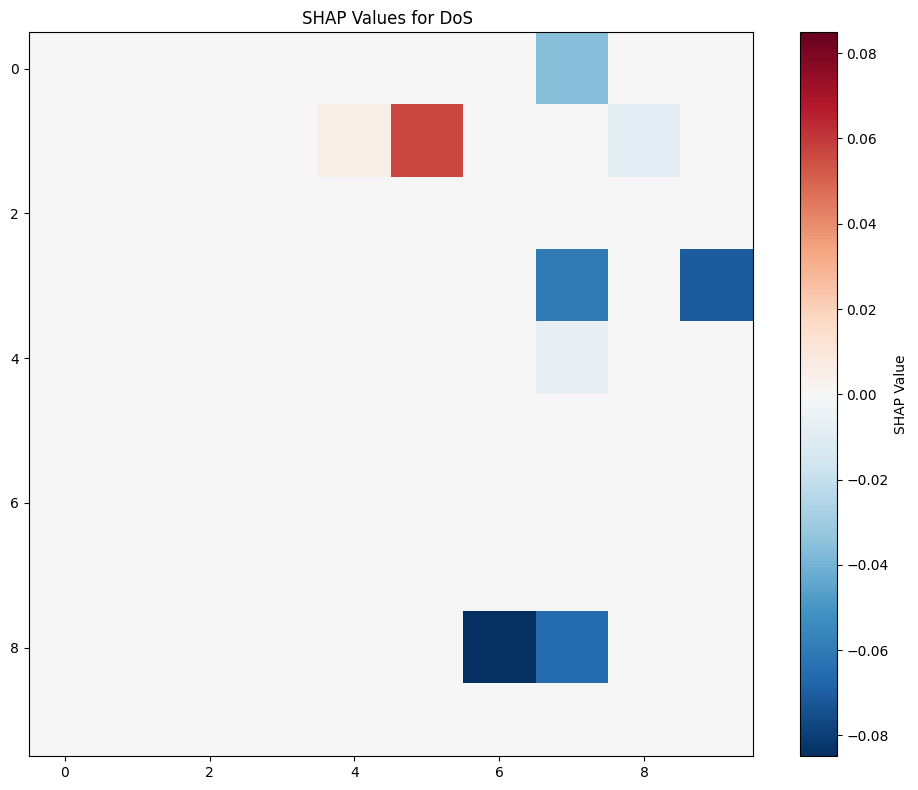

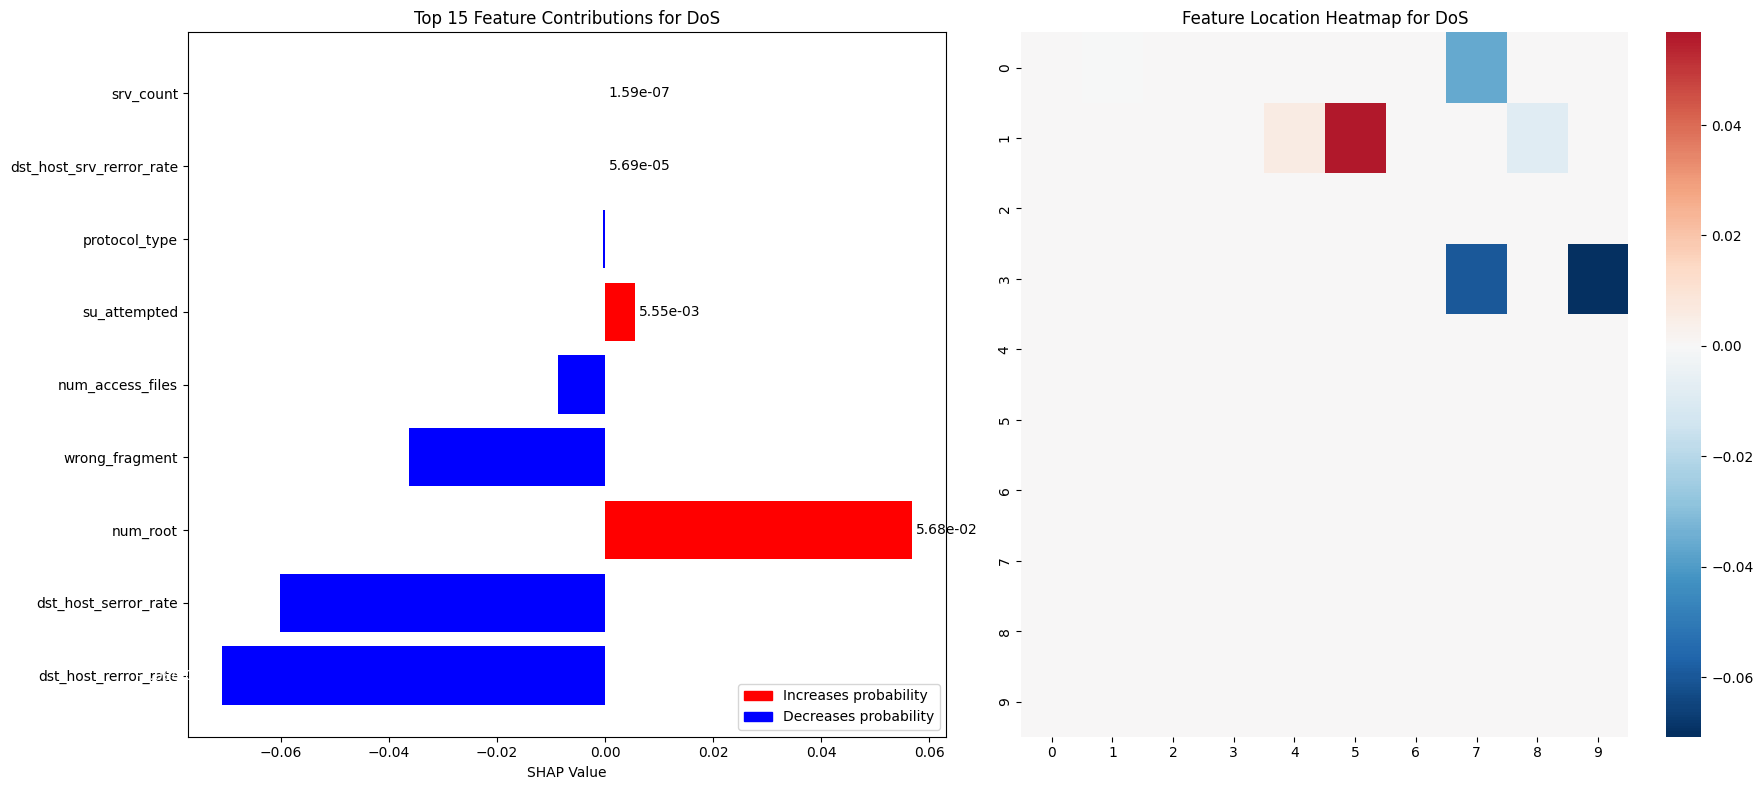

Rank,Feature,Description,Importance,Impact
1,dst_host_rerror_rate,% of REJ error connections to destination host,7.08e-02,Decreases probability
2,dst_host_serror_rate,% of SYN error connections to destination host,6.01e-02,Decreases probability
3,num_root,Number of 'root' accesses,5.68e-02,Increases probability
4,wrong_fragment,Number of 'wrong' fragments,3.63e-02,Decreases probability
5,num_access_files,Number of sensitive file access operations,8.70e-03,Decreases probability
6,su_attempted,1 if 'su root' command attempted; 0 otherwise,5.55e-03,Increases probability
7,protocol_type,"Type of protocol (e.g., tcp, udp, icmp)",2.74e-04,Decreases probability
8,dst_host_srv_rerror_rate,% of REJ error connections to destination host service,5.69e-05,Increases probability
9,srv_count,Number of connections to the same service in past 2 seconds,1.59e-07,Increases probability



🔹 Interpretation:
For DoS classification, the model is:
  Primarily focusing on (increasing probability):
    - num_root: Number of 'root' accesses
    - su_attempted: 1 if 'su root' command attempted; 0 otherwise
    - dst_host_srv_rerror_rate: % of REJ error connections to destination host service
  Being discouraged by (decreasing probability):
    - dst_host_rerror_rate: % of REJ error connections to destination host
    - dst_host_serror_rate: % of SYN error connections to destination host
    - wrong_fragment: Number of 'wrong' fragments

This would have  led to a DoS classification.

🔹 SHAP Analysis for Class: Probe 🟢 PREDICTED & TRUE CLASS
Description: Scanning and probing attacks attempt to gather information about the network to identify vulnerabilities. Characterized by connections to many ports/services in short time.
Class SHAP shape after squeezing: (10, 10)


C:\Users\arnav\AppData\Local\Temp\ipykernel_680\3990408614.py:250: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\IDS\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


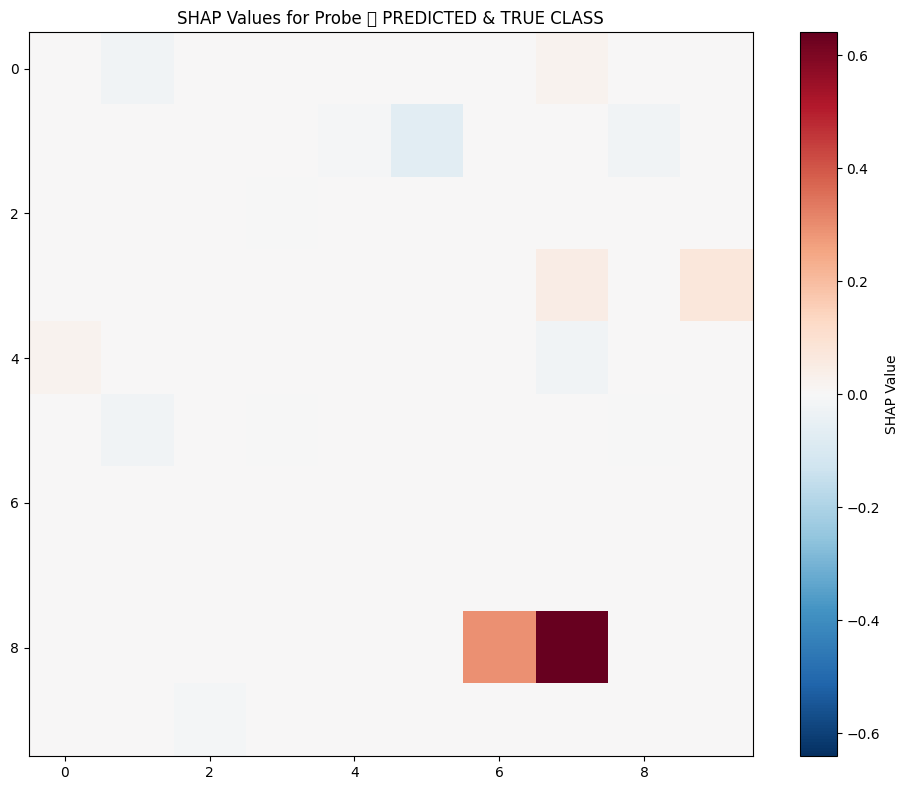

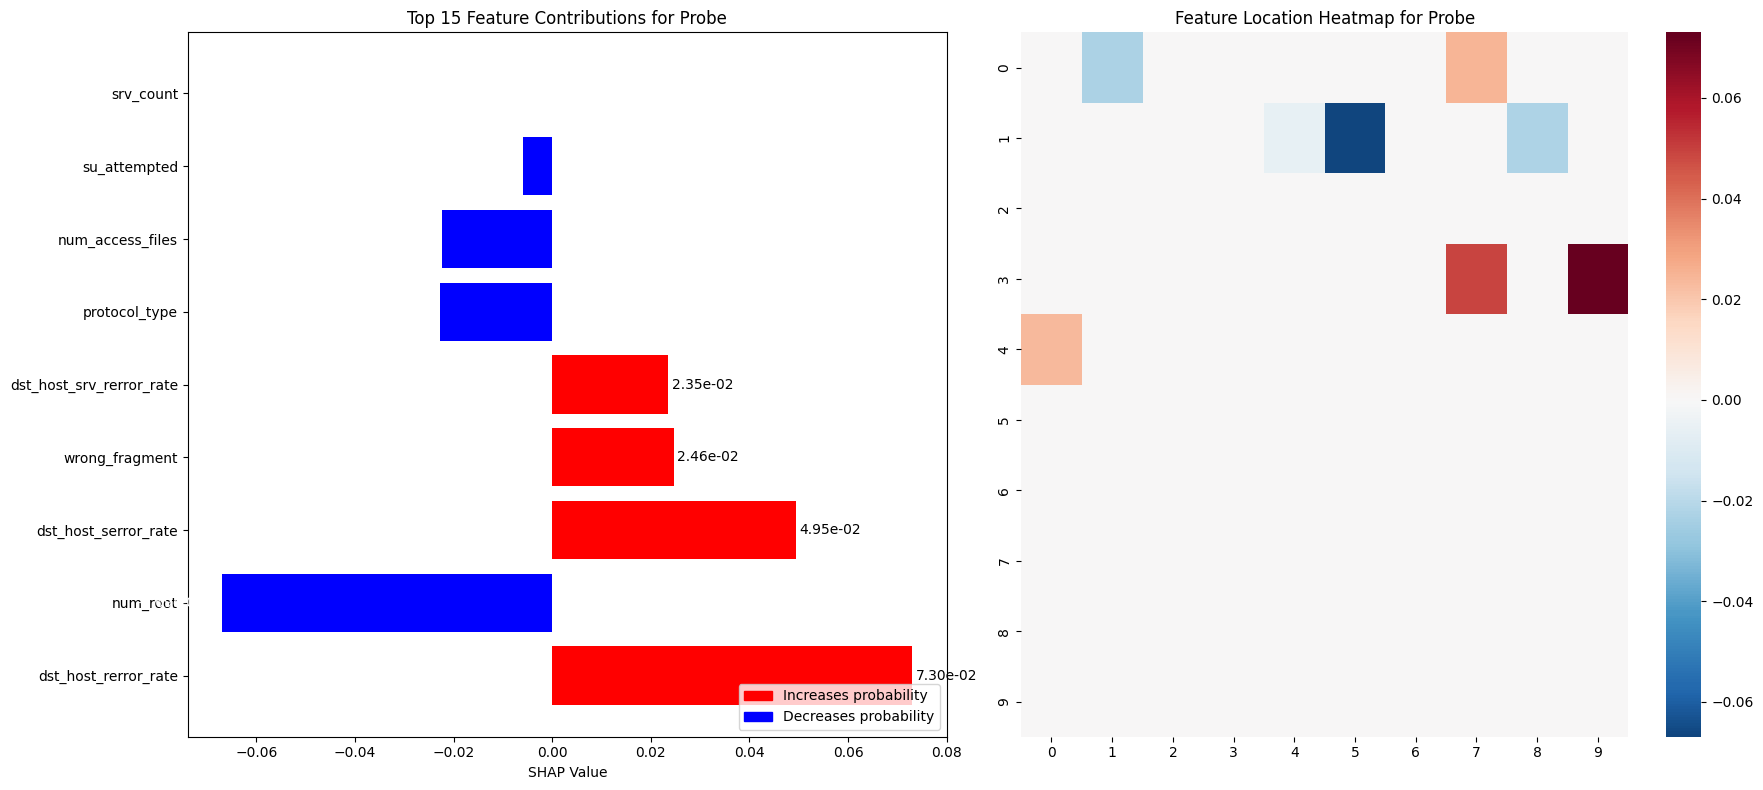

Rank,Feature,Description,Importance,Impact
1,dst_host_rerror_rate,% of REJ error connections to destination host,7.30e-02,Increases probability
2,num_root,Number of 'root' accesses,6.69e-02,Decreases probability
3,dst_host_serror_rate,% of SYN error connections to destination host,4.95e-02,Increases probability
4,wrong_fragment,Number of 'wrong' fragments,2.46e-02,Increases probability
5,dst_host_srv_rerror_rate,% of REJ error connections to destination host service,2.35e-02,Increases probability
6,protocol_type,"Type of protocol (e.g., tcp, udp, icmp)",2.27e-02,Decreases probability
7,num_access_files,Number of sensitive file access operations,2.23e-02,Decreases probability
8,su_attempted,1 if 'su root' command attempted; 0 otherwise,5.97e-03,Decreases probability
9,srv_count,Number of connections to the same service in past 2 seconds,2.23e-06,Decreases probability



🔹 Interpretation:
For Probe classification, the model is:
  Primarily focusing on (increasing probability):
    - dst_host_rerror_rate: % of REJ error connections to destination host
    - dst_host_serror_rate: % of SYN error connections to destination host
    - wrong_fragment: Number of 'wrong' fragments
  Being discouraged by (decreasing probability):
    - num_root: Number of 'root' accesses
    - protocol_type: Type of protocol (e.g., tcp, udp, icmp)
    - num_access_files: Number of sensitive file access operations

This  led to a Probe classification.

🔹 SHAP Analysis for Class: R2L 
Description: Remote to Local attacks attempt to gain unauthorized access from a remote machine. Characterized by unusual access patterns and credential manipulation.
Class SHAP shape after squeezing: (10, 10)


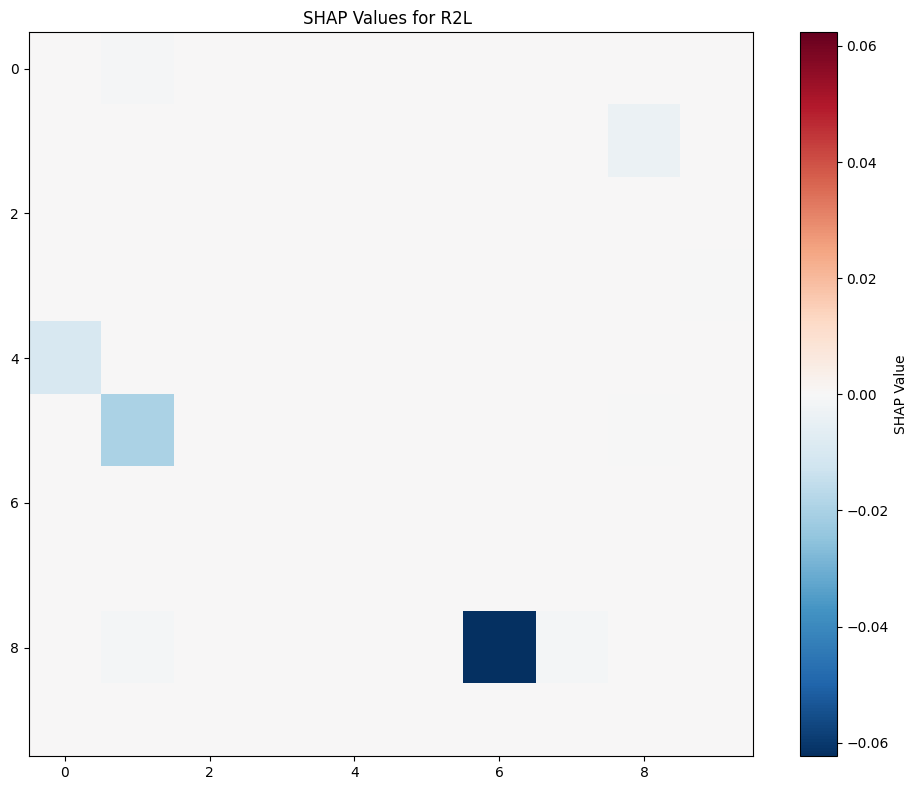

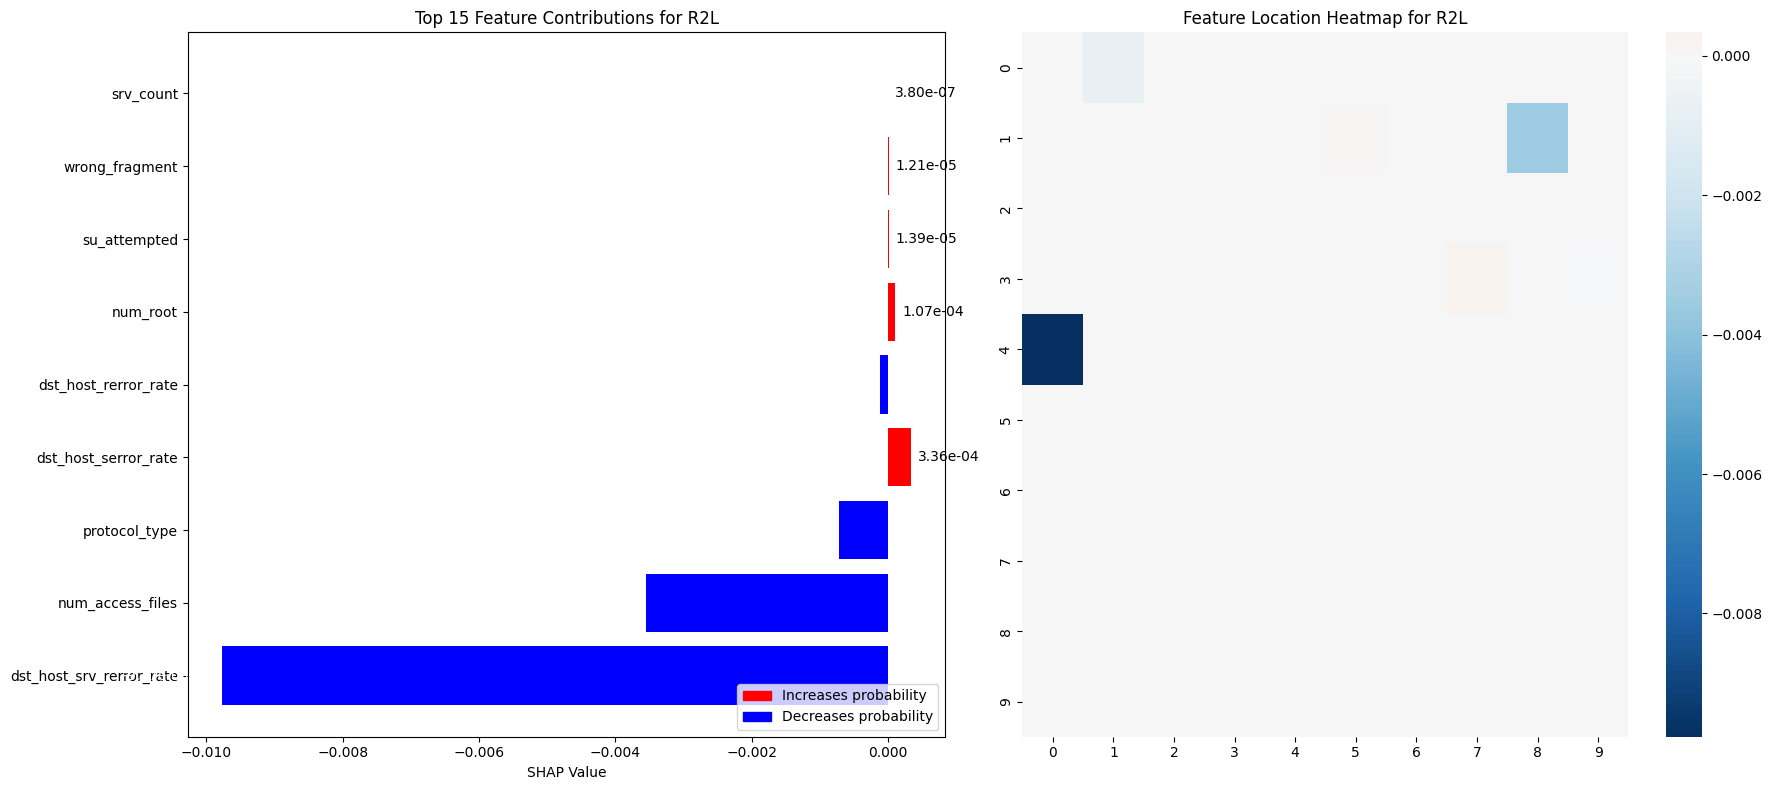

Rank,Feature,Description,Importance,Impact
1,dst_host_srv_rerror_rate,% of REJ error connections to destination host service,9.77e-03,Decreases probability
2,num_access_files,Number of sensitive file access operations,3.54e-03,Decreases probability
3,protocol_type,"Type of protocol (e.g., tcp, udp, icmp)",7.14e-04,Decreases probability
4,dst_host_serror_rate,% of SYN error connections to destination host,3.36e-04,Increases probability
5,dst_host_rerror_rate,% of REJ error connections to destination host,1.20e-04,Decreases probability
6,num_root,Number of 'root' accesses,1.07e-04,Increases probability
7,su_attempted,1 if 'su root' command attempted; 0 otherwise,1.39e-05,Increases probability
8,wrong_fragment,Number of 'wrong' fragments,1.21e-05,Increases probability
9,srv_count,Number of connections to the same service in past 2 seconds,3.80e-07,Increases probability



🔹 Interpretation:
For R2L classification, the model is:
  Primarily focusing on (increasing probability):
    - dst_host_serror_rate: % of SYN error connections to destination host
    - num_root: Number of 'root' accesses
    - su_attempted: 1 if 'su root' command attempted; 0 otherwise
  Being discouraged by (decreasing probability):
    - dst_host_srv_rerror_rate: % of REJ error connections to destination host service
    - num_access_files: Number of sensitive file access operations
    - protocol_type: Type of protocol (e.g., tcp, udp, icmp)

This would have  led to a R2L classification.

🔹 SHAP Analysis for Class: U2R 
Description: User to Root attacks attempt to gain root/admin privileges. Characterized by privilege escalation actions after gaining normal user access.
Class SHAP shape after squeezing: (10, 10)


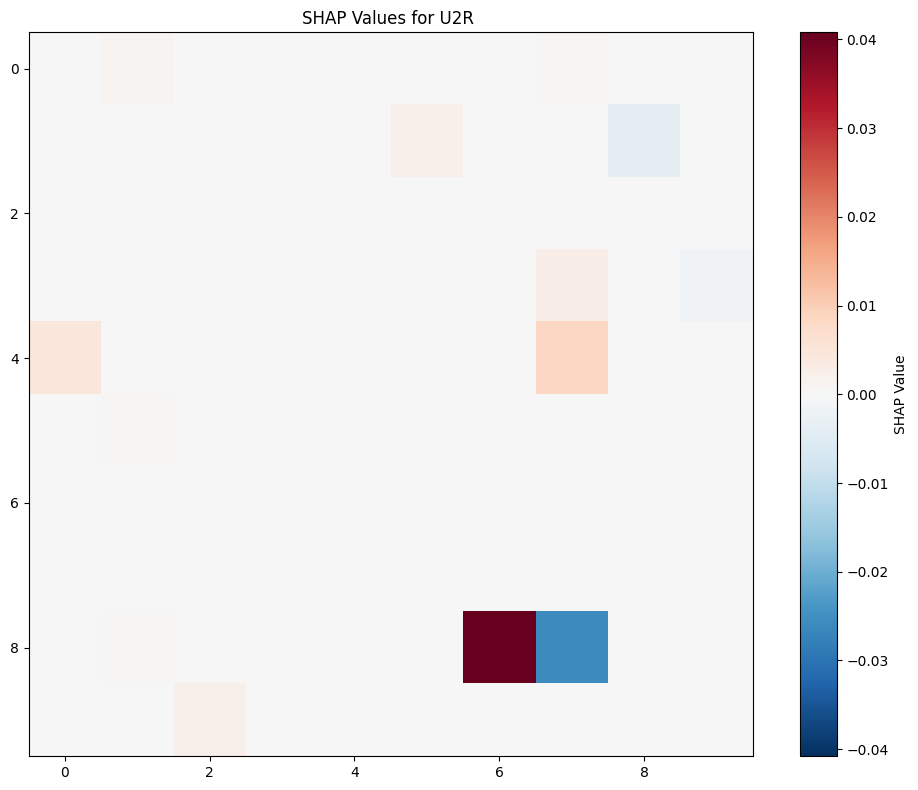

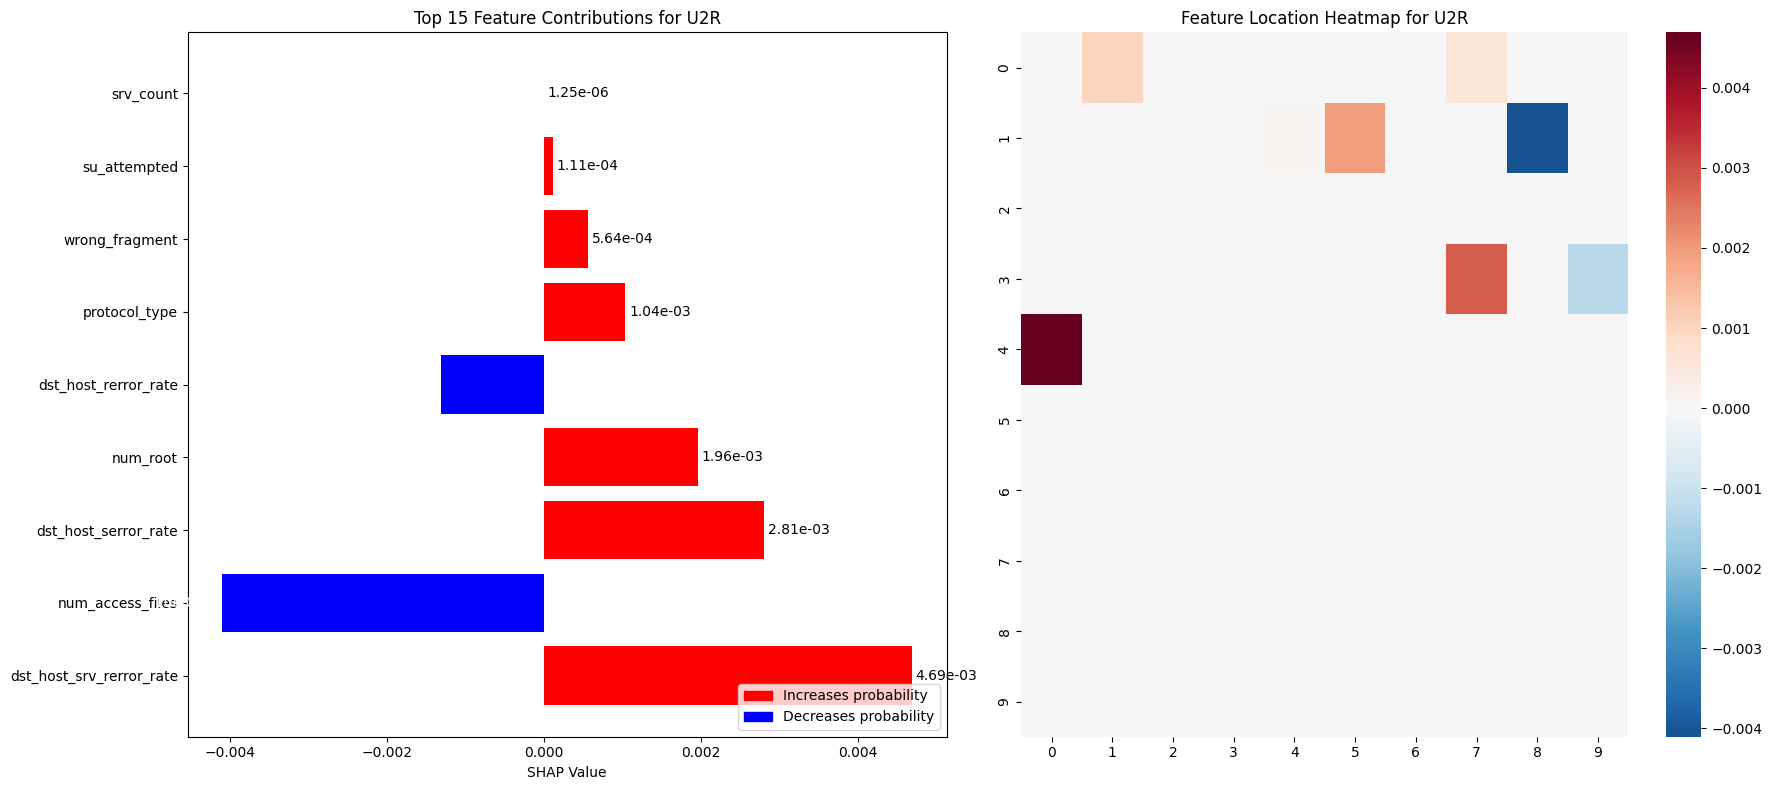

Rank,Feature,Description,Importance,Impact
1,dst_host_srv_rerror_rate,% of REJ error connections to destination host service,4.69e-03,Increases probability
2,num_access_files,Number of sensitive file access operations,4.10e-03,Decreases probability
3,dst_host_serror_rate,% of SYN error connections to destination host,2.81e-03,Increases probability
4,num_root,Number of 'root' accesses,1.96e-03,Increases probability
5,dst_host_rerror_rate,% of REJ error connections to destination host,1.31e-03,Decreases probability
6,protocol_type,"Type of protocol (e.g., tcp, udp, icmp)",1.04e-03,Increases probability
7,wrong_fragment,Number of 'wrong' fragments,5.64e-04,Increases probability
8,su_attempted,1 if 'su root' command attempted; 0 otherwise,1.11e-04,Increases probability
9,srv_count,Number of connections to the same service in past 2 seconds,1.25e-06,Increases probability



🔹 Interpretation:
For U2R classification, the model is:
  Primarily focusing on (increasing probability):
    - dst_host_srv_rerror_rate: % of REJ error connections to destination host service
    - dst_host_serror_rate: % of SYN error connections to destination host
    - num_root: Number of 'root' accesses
  Being discouraged by (decreasing probability):
    - num_access_files: Number of sensitive file access operations
    - dst_host_rerror_rate: % of REJ error connections to destination host

This would have  led to a U2R classification.

🔹 Cross-Class Feature Comparison:


Feature,Normal,DoS,Probe,R2L,U2R
dst_host_rerror_rate,-8.20e-04,-7.08e-02,+7.30e-02,-1.20e-04,-1.31e-03
dst_host_serror_rate,+7.47e-03,-6.01e-02,+4.95e-02,+3.36e-04,+2.81e-03
dst_host_srv_rerror_rate,-1.84e-02,+5.69e-05,+2.35e-02,-9.77e-03,+4.69e-03
num_access_files,+3.87e-02,-8.70e-03,-2.23e-02,-3.54e-03,-4.10e-03
num_root,+8.05e-03,+5.68e-02,-6.69e-02,+1.07e-04,+1.96e-03
protocol_type,+2.26e-02,-2.74e-04,-2.27e-02,-7.14e-04,+1.04e-03
srv_count,+4.43e-07,+1.59e-07,-2.23e-06,+3.80e-07,+1.25e-06
su_attempted,+2.92e-04,+5.55e-03,-5.97e-03,+1.39e-05,+1.11e-04
wrong_fragment,+1.11e-02,-3.63e-02,+2.46e-02,+1.21e-05,+5.64e-04



🔹 Original SHAP Visualization (Pixel Values):


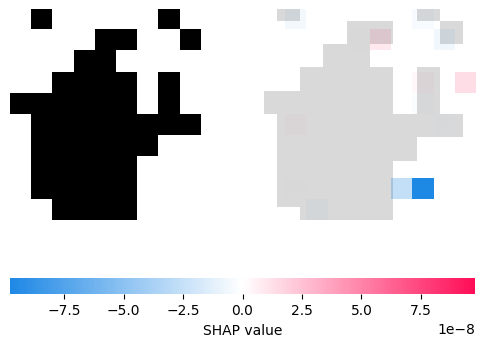

In [10]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.patches as mpatches

# Step 1: Define NSL-KDD feature names
def get_nsl_kdd_feature_names():
    """Return the list of feature names for the NSL-KDD dataset"""
    return [
        "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
        "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
        "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
        "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
        "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
        "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
    ]

# Feature descriptions for network security context
def get_feature_descriptions():
    """Return descriptions of the NSL-KDD features in a network security context"""
    return {
        "duration": "Length of the connection in seconds",
        "protocol_type": "Type of protocol (e.g., tcp, udp, icmp)",
        "service": "Network service on destination (e.g., http, ftp)",
        "flag": "Normal or error status of the connection",
        "src_bytes": "Bytes sent from source to destination",
        "dst_bytes": "Bytes sent from destination to source",
        "land": "1 if connection is from/to same host/port; 0 otherwise",
        "wrong_fragment": "Number of 'wrong' fragments",
        "urgent": "Number of urgent packets",
        "hot": "Number of 'hot' indicators (sensitive actions like accessing system files)",
        "num_failed_logins": "Number of failed login attempts",
        "logged_in": "1 if successfully logged in; 0 otherwise",
        "num_compromised": "Number of 'compromised' conditions",
        "root_shell": "1 if root shell is obtained; 0 otherwise",
        "su_attempted": "1 if 'su root' command attempted; 0 otherwise",
        "num_root": "Number of 'root' accesses",
        "num_file_creations": "Number of file creation operations",
        "num_shells": "Number of shell prompts",
        "num_access_files": "Number of sensitive file access operations",
        "num_outbound_cmds": "Number of outbound commands in an ftp session",
        "is_host_login": "1 if the login belongs to the 'hot' list; 0 otherwise",
        "is_guest_login": "1 if the login is a 'guest' login; 0 otherwise",
        "count": "Number of connections to the same host in past 2 seconds",
        "srv_count": "Number of connections to the same service in past 2 seconds",
        "serror_rate": "% of connections with SYN errors",
        "srv_serror_rate": "% of connections with SYN errors to the same service",
        "rerror_rate": "% of connections with REJ errors",
        "srv_rerror_rate": "% of connections with REJ errors to the same service",
        "same_srv_rate": "% of connections to the same service",
        "diff_srv_rate": "% of connections to different services",
        "srv_diff_host_rate": "% of connections to different hosts",
        "dst_host_count": "Count of connections to same destination host",
        "dst_host_srv_count": "Count of connections to same destination host service",
        "dst_host_same_srv_rate": "% of connections to same destination host service",
        "dst_host_diff_srv_rate": "% of connections to different destination host services",
        "dst_host_same_src_port_rate": "% of connections from same source port",
        "dst_host_srv_diff_host_rate": "% of connections to same service from different hosts",
        "dst_host_serror_rate": "% of SYN error connections to destination host",
        "dst_host_srv_serror_rate": "% of SYN error connections to destination host service",
        "dst_host_rerror_rate": "% of REJ error connections to destination host",
        "dst_host_srv_rerror_rate": "% of REJ error connections to destination host service"
    }

# Step 2: Update image model with feature names function
def update_image_model_with_features(image_model_path, param, feature_names=None):
    """ Update image model with feature names if they are missing """
    
    # Use NSL-KDD features if not provided
    if feature_names is None:
        feature_names = get_nsl_kdd_feature_names()
    
    # Load existing image model if available
    if os.path.exists(image_model_path):
        with open(image_model_path, 'rb') as f:
            image_model = pickle.load(f)
    else:
        # Create a basic image model structure
        image_model = {
            "xp": None,
            "yp": None,
            "A": param["Max_A_Size"],
            "B": param["Max_B_Size"],
            "custom_cut": None
        }
    
    # Add or update feature mapping
    if 'feature_mapping' not in image_model:
        image_model['feature_mapping'] = {
            'pixel_mapping': {},
            'feature_names': feature_names
        }
        
        # Create basic pixel mapping based on Cart2Pixel transformation
        for feature_idx, feature_name in enumerate(feature_names):
            if feature_idx < param["Max_A_Size"] * param["Max_B_Size"]:
                x = feature_idx % param["Max_A_Size"]
                y = feature_idx // param["Max_A_Size"]
                pixel_idx = y * param["Max_A_Size"] + x
                
                image_model['feature_mapping']['pixel_mapping'][str(pixel_idx)] = {
                    'feature_name': feature_name,
                    'x_coord': x + 1,
                    'y_coord': y + 1
                }
    
    # Save updated image model
    with open(image_model_path, 'wb') as f:
        pickle.dump(image_model, f)
    
    return image_model

# Define attack characteristics for better explanations
def get_attack_characteristics():
    """ Return characteristics of different attack types """
    return {
        "Normal": "Regular, benign network traffic with expected patterns and behaviors.",
        "DoS": "Denial of Service attacks attempt to make a network resource unavailable by flooding it with traffic or making it crash. Characterized by high volume of traffic to specific services.",
        "Probe": "Scanning and probing attacks attempt to gather information about the network to identify vulnerabilities. Characterized by connections to many ports/services in short time.",
        "R2L": "Remote to Local attacks attempt to gain unauthorized access from a remote machine. Characterized by unusual access patterns and credential manipulation.",
        "U2R": "User to Root attacks attempt to gain root/admin privileges. Characterized by privilege escalation actions after gaining normal user access."
    }

# Helper function to create default image model
def create_default_image_model(shape):
    """Creates a default image model with basic feature mapping"""
    image_size1, image_size2 = shape
    original_features = get_nsl_kdd_feature_names()
    
    image_model = {
        "xp": None,
        "yp": None,
        "A": image_size1,
        "B": image_size2,
        "custom_cut": None,
        "feature_mapping": {
            'pixel_mapping': {},
            'feature_names': original_features[:image_size1 * image_size2]
        }
    }
    
    # Create pixel mapping
    for i in range(min(len(original_features), image_size1 * image_size2)):
        x = i % image_size1
        y = i // image_size1
        pixel_idx = y * image_size1 + x
        image_model['feature_mapping']['pixel_mapping'][str(pixel_idx)] = {
            'feature_name': original_features[i],
            'x_coord': x + 1,
            'y_coord': y + 1
        }
    
    return image_model

# Helper function to map pixels to features
def map_pixels_to_features(flat_shap_values, image_model, num_features):
    """ Maps flattened SHAP values to features using image_model """
    image_size1 = image_model['A'] if 'A' in image_model else 10
    image_size2 = image_model['B'] if 'B' in image_model else 10
    
    feature_importance = {}
    
    # Process each pixel's SHAP value
    for pixel_idx, shap_value in enumerate(flat_shap_values):
        # Skip if value is close to zero (no impact)
        if abs(shap_value) < 1e-10:
            continue
            
        # Map pixel to feature
        pixel_key = str(pixel_idx)
        if 'feature_mapping' in image_model and 'pixel_mapping' in image_model['feature_mapping'] and pixel_key in image_model['feature_mapping']['pixel_mapping']:
            feature_info = image_model['feature_mapping']['pixel_mapping'][pixel_key]
            feature_name = feature_info['feature_name']
            
            # Add or update feature importance
            if feature_name not in feature_importance:
                feature_importance[feature_name] = {
                    'importance': float(shap_value),
                    'abs_importance': abs(float(shap_value)),
                    'coordinates': (feature_info['x_coord'], feature_info['y_coord']),
                    'type': 'positive' if shap_value > 0 else 'negative'
                }
            else:
                # If multiple pixels map to the same feature, use the one with the highest absolute value
                if abs(shap_value) > feature_importance[feature_name]['abs_importance']:
                    feature_importance[feature_name]['importance'] = float(shap_value)
                    feature_importance[feature_name]['abs_importance'] = abs(float(shap_value))
                    feature_importance[feature_name]['type'] = 'positive' if shap_value > 0 else 'negative'
    
    # Sort features by absolute importance
    sorted_features = sorted(
        feature_importance.items(),
        key=lambda x: x[1]['abs_importance'],
        reverse=True
    )[:num_features]  # Get top N features
    
    return sorted_features

# Function to directly analyze SHAP values for multi-class models
def analyze_direct_shap(shap_values, X_sample, image_model, attack_categories, 
                        feature_descriptions, attack_chars, y_pred, y_true, 
                        num_features=15, output_dir=None):
    """Analyze SHAP values when they're provided in the (samples, h, w, channels, num_classes) format"""
    print(f"SHAP values shape: {shap_values.shape}")
    image_size1, image_size2 = X_sample.shape[1], X_sample.shape[2]
    
    # Results dictionary
    class_analyses = {}
    
    for class_idx, class_name in enumerate(attack_categories):
        is_predicted = (class_idx == y_pred)
        is_true = (class_idx == y_true)
        
        status = ""
        if is_predicted and is_true:
            status = "🟢 PREDICTED & TRUE CLASS"
        elif is_predicted:
            status = "🟡 PREDICTED CLASS"
        elif is_true:
            status = "🔵 TRUE CLASS"
            
        print(f"\n🔹 SHAP Analysis for Class: {class_name} {status}")
        print(f"Description: {attack_chars[class_name]}")
        
        # Extract SHAP values for this class
        # For multi-dimensional SHAP values shape (1, h, w, 1, num_classes)
        class_shap = shap_values[..., class_idx]
        
        # Remove singleton dimensions
        class_shap = np.squeeze(class_shap)
        print(f"Class SHAP shape after squeezing: {class_shap.shape}")
        
        # Display class-specific SHAP heatmap
        plt.figure(figsize=(10, 8))
        # FIX: Use vmin/vmax instead of center for plt.imshow
        abs_max = np.max(np.abs(class_shap))
        plt.imshow(class_shap, cmap='RdBu_r', vmin=-abs_max, vmax=abs_max)
        plt.colorbar(label='SHAP Value')
        plt.title(f"SHAP Values for {class_name} {status}")
        plt.tight_layout()
        plt.show()
        
        # Flatten SHAP values for feature mapping
        flat_shap = class_shap.flatten()
        
        # Map pixels to features
        sorted_features = map_pixels_to_features(flat_shap, image_model, num_features)
        
        if not sorted_features:
            print("No significant feature importance values found for this class.")
            continue
        
        # Create visualization
        plt.figure(figsize=(18, 8))
        
        # 1. Feature Importance Plot
        plt.subplot(1, 2, 1)
        features = [x[0] for x in sorted_features]
        importance_values = [x[1]['importance'] for x in sorted_features]
        colors = ['red' if x[1]['type'] == 'positive' else 'blue' for x in sorted_features]
        
        # Create horizontal bar plot
        bars = plt.barh(range(len(features)), importance_values, color=colors)
        
        # Only add values to the bars if we have importance values
        if importance_values:
            max_importance = max([abs(x) for x in importance_values])
            for i, bar in enumerate(bars):
                value = importance_values[i]
                if value > 0:
                    plt.text(value + max_importance * 0.01, i, f"{value:.2e}", va='center')
                else:
                    plt.text(value - max_importance * 0.05, i, f"{value:.2e}", va='center', ha='right', color='white')
        
        plt.yticks(range(len(features)), [f"{f[:25]}..." if len(f) > 25 else f for f in features])
        plt.xlabel('SHAP Value')
        plt.title(f'Top {num_features} Feature Contributions for {class_name}')
        
        # Add legend
        red_patch = mpatches.Patch(color='red', label='Increases probability')
        blue_patch = mpatches.Patch(color='blue', label='Decreases probability')
        plt.legend(handles=[red_patch, blue_patch], loc='lower right')
        
        # 2. Pixel Location Plot
        plt.subplot(1, 2, 2)
        pixel_values = np.zeros((image_size1, image_size2))
        
        # Fill in pixel values from top features
        for feature_name, details in sorted_features:
            x, y = details['coordinates']
            # Ensure coordinates are within bounds and adjust to 0-indexed
            x = min(x-1, image_size1-1)
            y = min(y-1, image_size2-1)
            pixel_values[y, x] = details['importance']  # Note: y, x for array indexing
        
        # Create heatmap
        sns.heatmap(pixel_values, cmap='RdBu_r', center=0)
        plt.title(f'Feature Location Heatmap for {class_name}')
        
        plt.tight_layout()
        
        # Save the figure if output directory is provided
        if output_dir:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            plt.savefig(os.path.join(output_dir, f'feature_importance_{class_name}.png'))
        
        plt.show()
        
        # Create HTML table for feature importance with enhanced explanations
        table_html = f"""
        <h3>Top {min(num_features, len(sorted_features))} Features for {class_name} Classification {status}</h3>
        <table style="width:100%; border-collapse: collapse; margin-bottom: 20px;">
            <tr style="background-color: #f2f2f2;">
                <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Rank</th>
                <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Feature</th>
                <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Description</th>
                <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Importance</th>
                <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Impact</th>
            </tr>
        """
        
        for i, (feature_name, details) in enumerate(sorted_features):
            color = "#ffebee" if details['type'] == 'positive' else "#e3f2fd"
            impact = "Increases probability" if details['type'] == 'positive' else "Decreases probability"
            description = feature_descriptions.get(feature_name, "No description available")
            
            table_html += f"""
            <tr style="background-color: {color}">
                <td style="padding: 12px; border: 1px solid #ddd;">{i+1}</td>
                <td style="padding: 12px; border: 1px solid #ddd;">{feature_name}</td>
                <td style="padding: 12px; border: 1px solid #ddd;">{description}</td>
                <td style="padding: 12px; border: 1px solid #ddd;">{details['abs_importance']:.2e}</td>
                <td style="padding: 12px; border: 1px solid #ddd;">{impact}</td>
            </tr>
            """
        
        table_html += "</table>"
        display(HTML(table_html))
        
        # Provide interpretation of the results
        print("\n🔹 Interpretation:")
        print(f"For {class_name} classification, the model is:")
        
        # Get top 3 positive and negative features if available
        positive_features = [(name, details) for name, details in sorted_features if details['type'] == 'positive']
        negative_features = [(name, details) for name, details in sorted_features if details['type'] == 'negative']
        
        # Sort by absolute importance
        positive_features = sorted(positive_features, key=lambda x: x[1]['abs_importance'], reverse=True)[:3]
        negative_features = sorted(negative_features, key=lambda x: x[1]['abs_importance'], reverse=True)[:3]
        
        if positive_features:
            print("  Primarily focusing on (increasing probability):")
            for name, details in positive_features:
                print(f"    - {name}: {feature_descriptions.get(name, 'No description available')}")
        
        if negative_features:
            print("  Being discouraged by (decreasing probability):")
            for name, details in negative_features:
                print(f"    - {name}: {feature_descriptions.get(name, 'No description available')}")
        
        print(f"\nThis {'' if is_predicted else 'would have '} led to a {class_name} classification.")
        
        # Save class analysis
        class_analyses[class_name] = {
            'class_name': class_name,
            'shap_values': class_shap,
            'feature_importance': sorted_features,
            'is_predicted': is_predicted,
            'is_true': is_true
        }
    
    return class_analyses

# Main function for explainable AI
def explain_multi_class_prediction(model_path, test_data_path, test_labels_path, image_model_path=None, 
                                  num_features=15, output_dir=None, sample_idx=None, explain_all_classes=True):
    """
    Generate explanations for multi-class intrusion detection predictions.
    
    Parameters:
    -----------
    model_path : str
        Path to the trained model file
    test_data_path : str
        Path to the test data pickle file
    test_labels_path : str
        Path to the test labels pickle file
    image_model_path : str, optional
        Path to the image model pickle file (for feature mapping)
    num_features : int, default=15
        Number of top features to display
    output_dir : str, optional
        Directory to save output files
    sample_idx : int, optional
        Index of specific sample to explain (random if None)
    explain_all_classes : bool, default=True
        Whether to explain all classes or just the predicted and true classes
    
    Returns:
    --------
    dict
        Dictionary containing explanation results
    """
    # Attack category names and characteristics
    attack_categories = ["Normal", "DoS", "Probe", "R2L", "U2R"]
    attack_chars = get_attack_characteristics()
    feature_descriptions = get_feature_descriptions()
    
    # Load model
    print("Loading trained model...")
    model = load_model(model_path)
    print("Model loaded successfully.")
    
    # Load test data
    print("Loading test data...")
    with open(test_data_path, 'rb') as f:
        XTestGlobal = pickle.load(f)
    with open(test_labels_path, 'rb') as f:
        YTestGlobal = pd.read_pickle(f)
    
    # Convert to numpy array if needed
    XTestGlobal = np.array(XTestGlobal)
    
    # Try to load image_model for feature mapping
    if image_model_path and os.path.exists(image_model_path):
        print("Loading image model for feature mapping...")
        with open(image_model_path, 'rb') as f:
            image_model = pickle.load(f)
        print("Image model loaded successfully")
    else:
        print("Image model not found. Creating default feature mapping...")
        image_model = create_default_image_model(XTestGlobal.shape[1:3])
    
    # Reshape test data for the model
    image_size1, image_size2 = XTestGlobal.shape[1], XTestGlobal.shape[2]
    XTestGlobal_reshaped = np.reshape(XTestGlobal, (-1, image_size1, image_size2, 1))
    
    # Make predictions
    print("Making predictions...")
    Y_predicted_probs = model.predict(XTestGlobal_reshaped, verbose=1)
    Y_predicted = np.argmax(Y_predicted_probs, axis=1)
    
    # Display overall performance metrics
    print("\n🔹 Overall Performance Metrics:")
    accuracy = balanced_accuracy_score(YTestGlobal, Y_predicted)
    conf_matrix = confusion_matrix(YTestGlobal, Y_predicted)
    print(f"Balanced Accuracy: {accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Display classification report
    print("\n🔹 Classification Report:")
    report = classification_report(YTestGlobal, Y_predicted, target_names=attack_categories)
    print(report)
    
    # SHAP Analysis
    print("\n🔹 Generating SHAP explanations...")
    
    # Use a subset of data as background for the explainer
    background = XTestGlobal_reshaped[:20]  # Reduced from 50 to 20 samples to save memory
    
    # Select sample to explain (random if not specified)
    if sample_idx is None:
        sample_idx = np.random.choice(XTestGlobal_reshaped.shape[0])
    
    X_sample = XTestGlobal_reshaped[sample_idx:sample_idx+1]
    y_true = YTestGlobal[sample_idx]
    y_pred = Y_predicted[sample_idx]
    
    # Get prediction probabilities
    pred_probs = Y_predicted_probs[sample_idx]
    
    # Basic info about the sample
    print(f"\n🔹 Sample #{sample_idx}:")
    print(f"True Class: {attack_categories[y_true]}")
    print(f"Predicted Class: {attack_categories[y_pred]}")
    print("Prediction Probabilities:")
    for i, category in enumerate(attack_categories):
        print(f"  {category}: {pred_probs[i]:.4f}")
    
    # Print classification context
    print("\n🔹 Classification Context:")
    if y_true == y_pred:
        print(f"✅ This sample was correctly classified as {attack_categories[y_pred]}.")
        print(f"Description: {attack_chars[attack_categories[y_pred]]}")
    else:
        print(f"❌ This sample was misclassified as {attack_categories[y_pred]} when it was actually {attack_categories[y_true]}.")
        print(f"True class ({attack_categories[y_true]}): {attack_chars[attack_categories[y_true]]}")
        print(f"Predicted class ({attack_categories[y_pred]}): {attack_chars[attack_categories[y_pred]]}")
    
    try:
        # Create explainer with fewer background samples
        print("\n🔹 Creating SHAP explainer with smaller background...")
        explainer = shap.GradientExplainer(model, background)
        
        # Generate SHAP values for the sample
        print("Calculating SHAP values...")
        shap_values = explainer.shap_values(X_sample)
        
        # Debug SHAP values structure
        print("\n🔹 Debugging SHAP value structure:")
        print(f"SHAP values type: {type(shap_values)}")
        if isinstance(shap_values, list):
            print(f"SHAP values list length: {len(shap_values)}")
            for i, sv in enumerate(shap_values):
                print(f"  Class {i} shape: {np.array(sv).shape}")
                
            # Standard SHAP list - use normal approach
            class_analyses = {}
            # Loop through each attack category if explain_all_classes is True
            classes_to_analyze = range(len(attack_categories)) if explain_all_classes else [y_pred]
            
            for class_idx in classes_to_analyze:
                is_predicted = (class_idx == y_pred)
                is_true = (class_idx == y_true)
                class_name = attack_categories[class_idx]
                
                status = ""
                if is_predicted and is_true:
                    status = "🟢 PREDICTED & TRUE CLASS"
                elif is_predicted:
                    status = "🟡 PREDICTED CLASS"
                elif is_true:
                    status = "🔵 TRUE CLASS"
                
                print(f"\n🔹 Analyzing SHAP values for class: {class_name} {status}")
                
                # Get SHAP values for this class
                class_shap = shap_values[class_idx]
                flat_shap = class_shap.flatten()
                
                # Map to features
                sorted_features = map_pixels_to_features(flat_shap, image_model, num_features)
                
                if not sorted_features:
                    print(f"No significant features found for {class_name}")
                    continue
                
                # Create visualization
                plt.figure(figsize=(18, 8))
                
                # 1. Feature Importance Plot
                plt.subplot(1, 2, 1)
                features = [x[0] for x in sorted_features]
                importance_values = [x[1]['importance'] for x in sorted_features]
                colors = ['red' if x[1]['type'] == 'positive' else 'blue' for x in sorted_features]
                
                # Create horizontal bar plot
                bars = plt.barh(range(len(features)), importance_values, color=colors)
                
                # Add values to bars
                if importance_values:
                    max_importance = max([abs(x) for x in importance_values])
                    for i, bar in enumerate(bars):
                        value = importance_values[i]
                        if value > 0:
                            plt.text(value + max_importance * 0.01, i, f"{value:.2e}", va='center')
                        else:
                            plt.text(value - max_importance * 0.05, i, f"{value:.2e}", va='center', ha='right', color='white')
                
                plt.yticks(range(len(features)), [f"{f[:25]}..." if len(f) > 25 else f for f in features])
                plt.xlabel('SHAP Value')
                plt.title(f'Top {num_features} Feature Contributions for {class_name}')
                
                # Add legend
                red_patch = mpatches.Patch(color='red', label='Increases probability')
                blue_patch = mpatches.Patch(color='blue', label='Decreases probability')
                plt.legend(handles=[red_patch, blue_patch], loc='lower right')
                
                # 2. Pixel Location Plot
                plt.subplot(1, 2, 2)
                pixel_values = np.zeros((image_size1, image_size2))
                
                # Fill in pixel values from top features
                for feature_name, details in sorted_features:
                    x, y = details['coordinates']
                    # Ensure coordinates are within bounds and adjust to 0-indexed
                    x = min(x-1, image_size1-1)
                    y = min(y-1, image_size2-1)
                    pixel_values[y, x] = details['importance']  # Note: y, x for array indexing
                
                # Create heatmap
                sns.heatmap(pixel_values, cmap='RdBu_r', center=0)
                plt.title(f'Feature Location Heatmap for {class_name}')
                
                plt.tight_layout()
                
                # Save the figure if output directory is provided
                if output_dir:
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    plt.savefig(os.path.join(output_dir, f'feature_importance_{class_name}.png'))
                
                plt.show()
                
                # Create HTML table for feature importance with enhanced explanations
                table_html = f"""
                <h3>Top {min(num_features, len(sorted_features))} Features for {class_name} Classification {status}</h3>
                <table style="width:100%; border-collapse: collapse; margin-bottom: 20px;">
                    <tr style="background-color: #f2f2f2;">
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Rank</th>
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Feature</th>
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Description</th>
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Importance</th>
                        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Impact</th>
                    </tr>
                """
                
                for i, (feature_name, details) in enumerate(sorted_features):
                    color = "#ffebee" if details['type'] == 'positive' else "#e3f2fd"
                    impact = "Increases probability" if details['type'] == 'positive' else "Decreases probability"
                    description = feature_descriptions.get(feature_name, "No description available")
                    
                    table_html += f"""
                    <tr style="background-color: {color}">
                        <td style="padding: 12px; border: 1px solid #ddd;">{i+1}</td>
                        <td style="padding: 12px; border: 1px solid #ddd;">{feature_name}</td>
                        <td style="padding: 12px; border: 1px solid #ddd;">{description}</td>
                        <td style="padding: 12px; border: 1px solid #ddd;">{details['abs_importance']:.2e}</td>
                        <td style="padding: 12px; border: 1px solid #ddd;">{impact}</td>
                    </tr>
                    """
                
                table_html += "</table>"
                display(HTML(table_html))
                
                # Provide interpretation of the results
                print("\n🔹 Interpretation:")
                print(f"For {class_name} classification, the model is:")
                
                # Get top 3 positive and negative features if available
                positive_features = [(name, details) for name, details in sorted_features if details['type'] == 'positive']
                negative_features = [(name, details) for name, details in sorted_features if details['type'] == 'negative']
                
                # Sort by absolute importance
                positive_features = sorted(positive_features, key=lambda x: x[1]['abs_importance'], reverse=True)[:3]
                negative_features = sorted(negative_features, key=lambda x: x[1]['abs_importance'], reverse=True)[:3]
                
                if positive_features:
                    print("  Primarily focusing on (increasing probability):")
                    for name, details in positive_features:
                        print(f"    - {name}: {feature_descriptions.get(name, 'No description available')}")
                
                if negative_features:
                    print("  Being discouraged by (decreasing probability):")
                    for name, details in negative_features:
                        print(f"    - {name}: {feature_descriptions.get(name, 'No description available')}")
                
                print(f"\nThis {'' if is_predicted else 'would have '} led to a {class_name} classification.")
                
                # Add to class_analyses
                class_analyses[class_name] = {
                    'shap_values': class_shap, 
                    'feature_importance': sorted_features,
                    'is_predicted': is_predicted,
                    'is_true': is_true
                }
            
        elif isinstance(shap_values, np.ndarray):
            print(f"SHAP values shape: {shap_values.shape}")
            
            # Check if we have multi-class values in the last dimension
            if shap_values.shape[-1] == len(attack_categories):
                print("✅ Multi-class SHAP values detected in the last dimension")
                # Use direct analysis for multi-dimensional array
                class_analyses = analyze_direct_shap(shap_values, X_sample, image_model, 
                                                   attack_categories, feature_descriptions, 
                                                   attack_chars, y_pred, y_true, 
                                                   num_features, output_dir)
            else:
                print("⚠️ Unexpected SHAP values shape - cannot process")
                return None
        else:
            print("⚠️ Unexpected SHAP values type - cannot process")
            return None
        
        # Create cross-class comparison table if we have multiple classes
        if len(class_analyses) > 1:
            print("\n🔹 Cross-Class Feature Comparison:")
            all_important_features = set()
            class_feature_importance = {}
            
            for class_name, analysis in class_analyses.items():
                if 'feature_importance' in analysis:  # Check if analysis has feature importance
                    class_feature_importance[class_name] = {}
                    for feature_name, details in analysis['feature_importance']:
                        all_important_features.add(feature_name)
                        class_feature_importance[class_name][feature_name] = details['importance']
            
            # Create comparison table
            comparison_html = """
            <h3>Cross-Class Feature Comparison</h3>
            <p>This table shows how each important feature affects the probability of each attack class.</p>
            <table style="width:100%; border-collapse: collapse; margin-bottom: 20px;">
                <tr style="background-color: #f2f2f2;">
                    <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Feature</th>
            """
            
            # Add class headers
            for class_name in class_feature_importance.keys():
                comparison_html += f'<th style="padding: 12px; text-align: center; border: 1px solid #ddd;">{class_name}</th>'
            
            comparison_html += "</tr>"
            
            # Add feature rows
            for feature in sorted(all_important_features):
                comparison_html += f"""
                <tr>
                    <td style="padding: 12px; border: 1px solid #ddd;">{feature}</td>
                """
                
                for class_name in class_feature_importance.keys():
                    importance = class_feature_importance[class_name].get(feature, 0)
                    if abs(importance) < 1e-10:
                        # Negligible impact
                        cell_style = 'background-color: #f9f9f9; color: #888;'
                        cell_text = "0"
                    elif importance > 0:
                        # Positive impact (increases probability)
                        intensity = min(255, int(255 * (1 - min(1, importance * 100))))
                        cell_style = f'background-color: rgba(255, {intensity}, {intensity}, 0.8);'
                        cell_text = f"+{importance:.2e}"
                    else:
                        # Negative impact (decreases probability)
                        intensity = min(255, int(255 * (1 - min(1, abs(importance) * 100))))
                        cell_style = f'background-color: rgba({intensity}, {intensity}, 255, 0.8);'
                        cell_text = f"{importance:.2e}"
                    
                    comparison_html += f'<td style="padding: 12px; text-align: center; border: 1px solid #ddd; {cell_style}">{cell_text}</td>'
                
                comparison_html += "</tr>"
            
            comparison_html += "</table>"
            display(HTML(comparison_html))
            
            # Find distinguishing features if there's a misclassification
            if y_true != y_pred and attack_categories[y_true] in class_feature_importance and attack_categories[y_pred] in class_feature_importance:
                print("\n🔹 Cross-Class Insights:")
                
                true_class = attack_categories[y_true]
                pred_class = attack_categories[y_pred]
                
                true_class_features = class_feature_importance.get(true_class, {})
                pred_class_features = class_feature_importance.get(pred_class, {})
                
                # Find features that strongly favor the true class but were missed
                distinguishing_features = []
                for feature, true_importance in true_class_features.items():
                    pred_importance = pred_class_features.get(feature, 0)
                    if true_importance > 0 and (true_importance > pred_importance):
                        distinguishing_features.append((feature, true_importance - pred_importance))
                
                # Sort by importance difference
                distinguishing_features.sort(key=lambda x: x[1], reverse=True)
                
                if distinguishing_features:
                    print(f"Features that should have indicated {true_class} but were overlooked:")
                    for feature, diff in distinguishing_features[:3]:  # Top 3
                        print(f"  - {feature}: {feature_descriptions.get(feature, 'No description available')}")
                else:
                    print(f"No clear distinguishing features found that would indicate {true_class} over {pred_class}.")
        
        # Try to show original SHAP image plot
        try:
            print("\n🔹 Original SHAP Visualization (Pixel Values):")
            shap.image_plot(shap_values, X_sample, show=True)
        except Exception as e:
            print(f"Could not generate SHAP image plot: {e}")
        
        # Return results
        return {
            'sample_idx': sample_idx,
            'y_true': y_true,
            'y_pred': y_pred,
            'pred_probs': pred_probs,
            'class_analyses': class_analyses
        }
    
    except Exception as e:
        print(f"\n⚠️ Error generating SHAP explanations: {e}")
        print("\nFalling back to simplified feature importance analysis...")
        
        # Create a simplified feature importance visualization
        plt.figure(figsize=(14, 6))
        plt.title(f"Sample #{sample_idx}: {attack_categories[y_true]} classified as {attack_categories[y_pred]}")
        plt.imshow(X_sample[0, :, :, 0], cmap='viridis')
        plt.colorbar(label='Feature Value')
        plt.tight_layout()
        plt.show()
        
        # Return basic information
        return {
            'sample_idx': sample_idx,
            'y_true': y_true,
            'y_pred': y_pred,
            'pred_probs': pred_probs,
            'error': str(e)
        }

# Step 4: Configure parameters and execute analysis
# Update these paths to match your environment
param = {
    "Max_A_Size": 10,
    "Max_B_Size": 10,
    "Dynamic_Size": False,
    'Metod': 'tSNE',
    "ValidRatio": 0.1,
    "seed": 180,
    "dir": "D:/IDS/Code/Datasets/NSLKDD/",  # Update with your path
    "res": "D:/IDS/Code/Results/",  # Update with your path
    "Mode": "CNN2",  # CNN_Nature or CNN2
    "LoadFromJson": True,
    "mutual_info": True,
}

# Set paths
model_path = param["dir"] + "best_model.keras"
test_data_path = param["dir"] + f'test_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{"MI" if param["mutual_info"] else "Mean"}.pickle'
test_labels_path = param["dir"] + "Ytest.pickle"
image_model_path = param["dir"] + f'image_model_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{"MI" if param["mutual_info"] else "Mean"}.pickle'
output_dir = param["res"] + "explanations/"

# Update image model with feature names
update_image_model_with_features(image_model_path, param)

# Generate explanations
results = explain_multi_class_prediction(
    model_path=model_path,
    test_data_path=test_data_path,
    test_labels_path=test_labels_path,
    image_model_path=image_model_path,
    num_features=15,
    output_dir=output_dir,
    explain_all_classes=True  # Analyze all classes, not just predicted/true
)

Training Samples: 88181, Testing Samples: 37792
Feature Count: 41

🔹 First 5 rows of X_train:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.59424462e-07 1.32449077e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.87084149e-03 5.87084149e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.33342056e-08 3.51161819e-08 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0

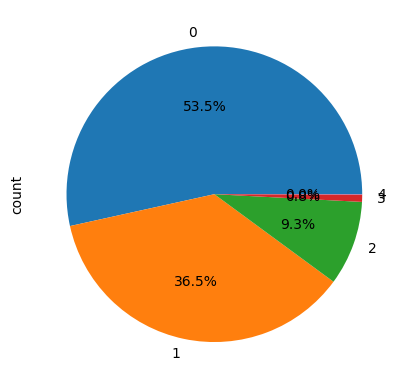

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

# 🔹 Define attack categories (mapping attacks to class labels)
attack_mapping = {
    'normal': 0,
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1, 'mailbomb': 1, 'apache2': 1,
    'processtable': 1, 'udpstorm': 1, 'worm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3, 'warezclient': 3,
    'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3,
    'httptunnel': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# ✅ Modified function to correctly map multi-class labels
def loadData(fromPath, LabelColumnName):
    """
    Loads the dataset, maps attack types to categories, and returns the dataset with features.
    """
    dataset = pd.read_csv(fromPath)

    # 🔹 Convert labels based on attack_mapping
    dataset[LabelColumnName] = dataset[LabelColumnName].map(attack_mapping)

    # 🔹 Handle unknown labels (if any)
    dataset = dataset.dropna(subset=[LabelColumnName])  # Drop rows with unknown attack types

    # 🔹 Plot label distribution
    dataset[LabelColumnName].value_counts().plot(kind='pie', autopct='%1.1f%%')

    featureList = dataset.drop([LabelColumnName], axis=1).columns
    return dataset, featureList

# ✅ Function to split dataset into features (X) and labels (y)
def datasetSplit(df, LabelColumnName):
    """
    Splits dataset into features (X) and labels (y), encodes labels, handles missing values, and normalizes data.
    """
    # 🔹 Convert all columns to numeric, forcing non-numeric values to NaN
    df = df.apply(pd.to_numeric, errors='coerce')

    # 🔹 Extract features and labels
    X = df.drop([LabelColumnName], axis=1).values  # Features
    y = df[LabelColumnName].values  # Labels

    # 🔹 Ensure X is strictly numeric (convert NaN and Inf values)
    X = np.array(X, dtype=np.float64)  # Convert to float to ensure compatibility

    # 🔹 Handle missing values
    for col in range(X.shape[1]):
        if np.isnan(X[:, col]).all():  # If entire column is NaN, replace with zeros
            X[:, col] = 0
        else:
            median = np.nanmedian(X[:, col])  # Get median for the column
            X[:, col] = np.nan_to_num(X[:, col], nan=median, posinf=0, neginf=0)  # Replace NaN and Inf values

    # 🔹 Normalize features
    scaler = preprocessing.MinMaxScaler()
    X = scaler.fit_transform(X)

    return X, y

# ✅ Function to split dataset into training and testing sets
def train_test_dataset(df, LabelColumnName):
    """
    Splits dataset into train-test sets, encodes labels, ensures numeric features, and handles missing values.
    """
    # 🔹 Convert all columns to numeric, forcing non-numeric values to NaN
    df = df.apply(pd.to_numeric, errors='coerce')

    # 🔹 Encode labels
    labelencoder = LabelEncoder()
    df[LabelColumnName] = labelencoder.fit_transform(df[LabelColumnName])

    # 🔹 Extract features and labels
    X = df.drop([LabelColumnName], axis=1).values  # Features
    y = df[[LabelColumnName]].values  # Labels

    # 🔹 Ensure X is strictly numeric
    X = np.array(X, dtype=np.float64)  # Convert to float for numerical operations

    # 🔹 Handle missing and infinite values
    for col in range(X.shape[1]):
        if np.isnan(X[:, col]).all():  # If entire column is NaN, replace with zeros
            X[:, col] = 0
        else:
            median = np.nanmedian(X[:, col])  # Compute median safely
            X[:, col] = np.nan_to_num(X[:, col], nan=median, posinf=0, neginf=0)  # Replace NaN/Inf with median or zero

    # 🔹 Normalize features
    scaler = preprocessing.MinMaxScaler()
    X = scaler.fit_transform(X)

    # 🔹 Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0, stratify=y)

    return X_train, X_test, y_train, y_test


# ✅ Load and process the dataset
fromPath = "/content/IDS/Datasets/NSL_KDD_Train.csv"
LabelColumnName = 'classification'

dataset, featureList = loadData(fromPath, LabelColumnName)
X, y = datasetSplit(dataset, LabelColumnName)
X_train, X_test, y_train, y_test = train_test_dataset(dataset, LabelColumnName)

# 🔹 Print dataset shape
print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")
print(f"Feature Count: {X_train.shape[1]}")

print("\n🔹 First 5 rows of X_train:")
print(X_train[:10])

print("\n🔹 First 5 labels in y_train:")
print(y_train[:10])

# Print first 5 rows of X_test and y_test
print("\n🔹 First 5 rows of X_test:")
print(X_test[:10])

print("\n🔹 First 5 labels in y_test:")
print(y_test[:10])


Empty DataFrame
Columns: [duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, classification]
Index: []

[0 rows x 42 columns]
Empty DataFrame
Columns: [duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_h

<ipython-input-2-5101f3007028>:12: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


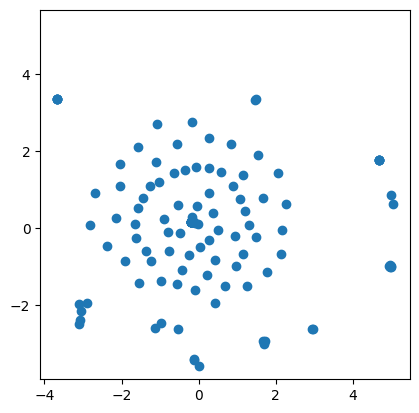

Collisioni: 79
calc MI


KeyboardInterrupt: 

In [ ]:
import json
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Parameters
param = {
    "Max_A_Size": 10,
    "Max_B_Size": 10,
    "Dynamic_Size": False,
    'Metod': 'tSNE',
    "ValidRatio": 0.1,
    "seed": 180,
    "dir": "/content/IDS/Datasets/NSL_KDD",
    "Mode": "CNN2",  # CNN_Nature, CNN2
    "res": "/content/IDS/Results/",
    "LoadFromJson": False,
    "mutual_info": True,  # True: Mutual Information, False: Mean
    "hyper_opt_evals": 20,
    "epoch": 150,
    "No_0_MI": False,
    "autoencoder": False,
    "cut": None,
    "enhanced_dataset": "gan"  # Options: gan, smote, adasyn, None
}

# Attack categories mapping
attack_mapping = {
    'normal': 0,
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1, 'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3, 'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'httptunnel': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# Select dataset
dataset = 3
if dataset == 1:
    train = 'TrainOneCls.csv'
    test = 'Test.csv'
    classif_label = 'Classification'
elif dataset == 2:
    train = 'Train.csv'
    test = 'Test_UNSW_NB15.csv'
    classif_label = 'classification'
elif dataset == 3:
    train = 'NSL_KDD_Train.csv'
    test = 'NSL_KDD_Test.csv'
    classif_label = 'classification'
elif dataset == 4:
    train = 'AAGMTrain_OneClsNumeric.csv'
    test = 'AAGMTest_OneClsNumeric.csv'
    classif_label = 'classification'

def preprocess_data(df, categorical_features, label_column, encoder=None, scaler=None, fit_transform=True):
    """ Converts categorical features to numerical, normalizes data, and encodes labels """
    # Extract numerical features
    numerical_features = df.drop(columns=categorical_features + [label_column]).columns

    # One-Hot Encoding
    if fit_transform:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        categorical_data = encoder.fit_transform(df[categorical_features])
    else:
        categorical_data = encoder.transform(df[categorical_features])

    categorical_df = pd.DataFrame(categorical_data, columns=encoder.get_feature_names_out(categorical_features))

    # Merge numerical & one-hot encoded features
    df_processed = pd.concat([df[numerical_features], categorical_df], axis=1)

    # Normalize features
    if fit_transform:
        scaler = MinMaxScaler()
        df_processed[df_processed.columns] = scaler.fit_transform(df_processed)
    else:
        df_processed[df_processed.columns] = scaler.transform(df_processed)

    # Convert labels
    y = df[label_column].map(attack_mapping)

    return df_processed, y, encoder, scaler

if not param["LoadFromJson"]:
    # Load Train Data
    df_train = pd.read_csv(os.path.join(param["dir"], train))
    df_test = pd.read_csv(os.path.join(param["dir"], test))

    print(df_train[:0])
    print(df_test[:0])

    categorical_features = ["protocol_type", "service", "flag"]

    X_train, y_train, encoder, scaler = preprocess_data(df_train, categorical_features, classif_label, fit_transform=True)
    X_test, y_test, _, _ = preprocess_data(df_test, categorical_features, classif_label, encoder, scaler, fit_transform=False)

    # Apply SMOTE or ADASYN if required
    if param["enhanced_dataset"] == "smote":
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    elif param["enhanced_dataset"] == "adasyn":
        ada = ADASYN(random_state=42)
        X_train, y_train = ada.fit_resample(X_train, y_train)

    # Save preprocessed data
    with open(os.path.join(param["dir"], "Xtrain.pickle"), "wb") as f:
        pickle.dump(X_train, f)
    with open(os.path.join(param["dir"], "Xtest.pickle"), "wb") as f:
        pickle.dump(X_test, f)
    with open(os.path.join(param["dir"], "Ytrain.pickle"), "wb") as f:
        pickle.dump(y_train, f)
    with open(os.path.join(param["dir"], "Ytest.pickle"), "wb") as f:
        pickle.dump(y_test, f)
    print("\n🔹 First 5 rows of X_train:")
    print(X_train[:5])

    print("\n🔹 First 5 labels in y_train:")
    print(y_train[:5])

    # Print first 5 rows of X_test and y_test
    print("\n🔹 First 5 rows of X_test:")
    print(X_test[:5])

    print("\n🔹 First 5 labels in y_test:")
    print(y_test[:5])

    print("✅ Data preprocessing complete. Files saved as pickle.")

    # Convert to images using Cart2Pixel
    data = {"Xtrain": X_train, "Xtest": X_test, "Classification": y_train, "Ytest": y_test}
    model = train_norm(param, data, norm=False)

else:
    # Load preprocessed images
    images = {}
    method = 'MI' if param['mutual_info'] else 'Mean'

    with open(param["dir"] + f'train_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{method}.pickle', 'rb') as f:
        images["Xtrain"] = pickle.load(f)
    with open(param["dir"] + 'YTrain.pickle', 'rb') as f:
        images["Classification"] = pickle.load(f)
    with open(param["dir"] + f'test_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{method}.pickle', 'rb') as f:
        images["Xtest"] = pickle.load(f)
    with open(param["dir"] + 'YTest.pickle', 'rb') as f:
        images["Ytest"] = pickle.load(f)

    model = train_norm(param, images, norm=False)


In [ ]:
import json
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Parameters
param = {
    "Max_A_Size": 10,
    "Max_B_Size": 10,
    "Dynamic_Size": False,
    'Metod': 'tSNE',
    "ValidRatio": 0.1,
    "seed": 180,
    "dir": "/content/IDS/Datasets/NSL_KDD/",
    "Mode": "CNN2",  # CNN_Nature, CNN2
    "res": "/content/IDS/Results/",
    "LoadFromJson": True,
    "mutual_info": True,  # True: Mutual Information, False: Mean
    "hyper_opt_evals": 20,
    "epoch": 150,
    "No_0_MI": False,
    "autoencoder": False,
    "cut": None,
    "enhanced_dataset": "gan"  # Options: gan, smote, adasyn, None
}

# Attack categories mapping
attack_mapping = {
    'normal': 0,
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1, 'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3, 'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'httptunnel': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# Select dataset
dataset = 3
if dataset == 1:
    train = 'TrainOneCls.csv'
    test = 'Test.csv'
    classif_label = 'Classification'
elif dataset == 2:
    train = 'Train.csv'
    test = 'Test_UNSW_NB15.csv'
    classif_label = 'classification'
elif dataset == 3:
    train = 'NSL_KDD_Train.csv'
    test = 'NSL_KDD_Test.csv'
    classif_label = 'classification'
elif dataset == 4:
    train = 'AAGMTrain_OneClsNumeric.csv'
    test = 'AAGMTest_OneClsNumeric.csv'
    classif_label = 'classification'

def preprocess_data(df, categorical_features, label_column, encoder=None, scaler=None, fit_transform=True):
    """ Converts categorical features to numerical, normalizes data, and encodes labels """
    # Extract numerical features
    numerical_features = df.drop(columns=categorical_features + [label_column]).columns

    # One-Hot Encoding
    if fit_transform:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        categorical_data = encoder.fit_transform(df[categorical_features])
    else:
        categorical_data = encoder.transform(df[categorical_features])

    categorical_df = pd.DataFrame(categorical_data, columns=encoder.get_feature_names_out(categorical_features))

    # Merge numerical & one-hot encoded features
    df_processed = pd.concat([df[numerical_features], categorical_df], axis=1)

    # Normalize features
    if fit_transform:
        scaler = MinMaxScaler()
        df_processed[df_processed.columns] = scaler.fit_transform(df_processed)
    else:
        df_processed[df_processed.columns] = scaler.transform(df_processed)

    # Convert labels
    y = df[label_column].map(attack_mapping)

    return df_processed, y, encoder, scaler

if not param["LoadFromJson"]:
    # Load Train Data
    df_train = pd.read_csv(os.path.join(param["dir"], train))
    df_test = pd.read_csv(os.path.join(param["dir"], test))

    print(df_train[:0])
    print(df_test[:0])

    categorical_features = ["protocol_type", "service", "flag"]

    X_train, y_train, encoder, scaler = preprocess_data(df_train, categorical_features, classif_label, fit_transform=True)
    X_test, y_test, _, _ = preprocess_data(df_test, categorical_features, classif_label, encoder, scaler, fit_transform=False)

    # Apply SMOTE or ADASYN if required
    if param["enhanced_dataset"] == "smote":
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    elif param["enhanced_dataset"] == "adasyn":
        ada = ADASYN(random_state=42)
        X_train, y_train = ada.fit_resample(X_train, y_train)

    # Save preprocessed data
    with open(os.path.join(param["dir"], "Xtrain.pickle"), "wb") as f:
        pickle.dump(X_train, f)
    with open(os.path.join(param["dir"], "Xtest.pickle"), "wb") as f:
        pickle.dump(X_test, f)
    with open(os.path.join(param["dir"], "Ytrain.pickle"), "wb") as f:
        pickle.dump(y_train, f)
    with open(os.path.join(param["dir"], "Ytest.pickle"), "wb") as f:
        pickle.dump(y_test, f)
    print("\n🔹 First 5 rows of X_train:")
    print(X_train[:5])

    print("\n🔹 First 5 labels in y_train:")
    print(y_train[:5])

    # Print first 5 rows of X_test and y_test
    print("\n🔹 First 5 rows of X_test:")
    print(X_test[:5])

    print("\n🔹 First 5 labels in y_test:")
    print(y_test[:5])

    print("✅ Data preprocessing complete. Files saved as pickle.")

    # Convert to images using Cart2Pixel
    data = {"Xtrain": X_train, "Xtest": X_test, "Classification": y_train, "Ytest": y_test}
    # model = train_norm(param, data, norm=False)
    generate_images(param, data, norm=False)

else:
    # Load preprocessed images
    images = {}
    method = 'MI' if param['mutual_info'] else 'Mean'

    with open(param["dir"] + 'XTrain50A%.pickle', 'rb') as f:
        images["Xtrain"] = pickle.load(f)
    with open(param["dir"] + 'YTrain50A%.pickle', 'rb') as f:
        images["Classification"] = pickle.load(f)
    with open(param["dir"] + f'test_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{method}.pickle', 'rb') as f:
        images["Xtest"] = pickle.load(f)
    with open(param["dir"] + 'Ytest.pickle', 'rb') as f:
        images["Ytest"] = pickle.load(f)

    if param["enhanced_dataset"] == "smote":
        sm = SMOTE(random_state=42)
        images["Xtrain"], images["Classification"] = sm.fit_resample(images["Xtrain"], images["Classification"])
    elif param["enhanced_dataset"] == "adasyn":
        ada = ADASYN(random_state=42)
        images["Xtrain"], images["Classification"] = ada.fit_resample(images["Xtrain"], images["Classification"])


    # generate_images(param, images, norm=False)
    model = train_norm(param, images, norm=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/IDS/Datasets/NSL_KDD/XTrain50A%.pickle'